# Prophet 분석 (Walk-Forward 방식 적용)

## 분석 개요
이 노트북은 **2주 이동평균(Smoothing)을 적용한 바이럴 지수**를 외생 변수로 사용하여,
경제/경영 도서 **전체 10개 카테고리**의 판매 점수를 예측합니다.

## 분석 설정
- **Walk-Forward 방식**: Data Leakage 방지
- **최소 학습 기간**: 5주 (1~5주차는 학습용, 6주차부터 예측)
- **누락값 처리**: 1~5주차는 카테고리별 평균값으로 대체

## 분석 대상 카테고리 (10개)
거시경제/금융정책, 경제이론/학술, 금융시스템/위기, 기업경영/리더십, 부동산/실물자산,
재테크/개인금융, 주식투자/트레이딩, 지정학/국제정세, 테크/스타트업, 투자철학/대가

---
## Walk-Forward 방식이란?

### 기존 방식의 문제점 (Data Leakage)
```
[기존 방식]
전체 데이터(1~50주)로 Prophet 학습
→ 전체 데이터(1~50주)에 대한 예측값 생성
→ 이 예측값을 ML 피처로 사용

⚠️ 문제: 30주차 예측에 31~50주차 정보가 이미 반영됨 (미래 정보 누수)
```

### Walk-Forward 방식 (Data Leakage 방지)
```
[Walk-Forward 방식] - 최소 학습 기간: 5주
1~5주 데이터로 학습 → 6주차 예측값 생성
1~6주 데이터로 학습 → 7주차 예측값 생성
1~7주 데이터로 학습 → 8주차 예측값 생성
...

✅ 장점: 각 시점에서 "당시 알 수 있었던 정보만" 사용
✅ 장점: 실제 운영 환경과 동일한 조건
✅ 장점: 더 신뢰할 수 있는 성능 평가
```

### 누락값 처리
```
1~5주차: Walk-Forward 예측값 없음 (학습 기간)
       → 카테고리별 전체 평균값으로 대체
       → ML 피처로 사용 시 "is_imputed" 플래그로 표시
```

---
## 1. 라이브러리 및 데이터 로드

In [13]:
import os
import pandas as pd
import numpy as np
from prophet import Prophet
from supabase import create_client
from dotenv import load_dotenv
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from prophet.utilities import regressor_coefficients
import warnings
warnings.filterwarnings('ignore')

load_dotenv()

plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

supabase = create_client(os.getenv("SUPABASE_URL"), os.getenv("SUPABASE_KEY"))
print("✅ 라이브러리 로드 완료")

✅ 라이브러리 로드 완료


In [14]:
# 데이터 로드
viral_df = pd.read_csv("../weekly_news_viral_index.csv")
viral_df['ymw'] = viral_df['ymw'].astype(str)
viral_df['end_date'] = pd.to_datetime(viral_df['end_date'])

bs_res = supabase.table('weekly_bestsellers').select('ymw, rank, product_code').execute()
books_res = supabase.table('books').select('product_code, category_1').execute()

df_bs = pd.DataFrame(bs_res.data)
df_books = pd.DataFrame(books_res.data)
df_merged = pd.merge(df_bs, df_books, on='product_code', how='left')

# Y 변수: 순위 가중 점수
df_merged['weight'] = 21 - df_merged['rank']
bs_weighted = df_merged.groupby(['ymw', 'category_1'])['weight'].sum().unstack(fill_value=0)

print(f"✅ 데이터 로드 완료")
print(f"   - 바이럴 지수: {len(viral_df)}행")
print(f"   - 베스트셀러: {len(df_bs)}행")
print(f"   - 카테고리 수: {len(bs_weighted.columns)}개")

✅ 데이터 로드 완료
   - 바이럴 지수: 583행
   - 베스트셀러: 1000행
   - 카테고리 수: 10개


---
## 2. Walk-Forward Prophet 함수 정의

In [15]:
def prepare_category_data(category_name, lag_weeks=0):
    """
    카테고리별 Prophet 분석용 데이터 준비
    
    Parameters:
    - category_name: 분석할 카테고리명
    - lag_weeks: 바이럴 지수 시차 (0=동시간대, 1=1주전, ...)
    
    Returns:
    - df_prophet: Prophet 형식 데이터프레임 (ds, y, reg)
    """
    # 해당 카테고리 바이럴 지수
    cat_viral = viral_df[viral_df['category'] == category_name].copy()
    
    # 해당 카테고리 판매 점수
    if category_name not in bs_weighted.columns:
        print(f"⚠️ {category_name} 카테고리가 베스트셀러에 없습니다.")
        return None
    
    cat_bs = bs_weighted[category_name].reset_index()
    cat_bs.columns = ['ymw', 'y']
    cat_bs['ymw'] = cat_bs['ymw'].astype(str)
    
    # 병합
    df_model = pd.merge(cat_viral, cat_bs, on='ymw')
    df_model = df_model.rename(columns={'end_date': 'ds'})
    df_model = df_model.sort_values('ds').reset_index(drop=True)
    
    # 시차 적용
    df_model['reg_raw'] = df_model['viral_index_smoothed'].shift(lag_weeks)
    
    # 결측치 제거 및 필요 컬럼만 선택
    df_prophet = df_model[['ds', 'y', 'reg_raw']].dropna().reset_index(drop=True)
    
    return df_prophet

In [16]:
def walk_forward_prophet(df, min_train_size=10, verbose=False):
    """
    Walk-Forward 방식으로 Prophet 예측값 생성 (Data Leakage 방지)
    
    Parameters:
    - df: Prophet 형식 데이터프레임 (ds, y, reg_raw)
    - min_train_size: 최소 학습 데이터 크기 (주 단위)
    - verbose: 진행 상황 출력 여부
    
    Returns:
    - results_df: 각 시점별 실제값, 예측값, 잔차 포함 데이터프레임
    - coefficients: 각 시점별 회귀 계수 리스트
    """
    n = len(df)
    predictions = []
    actuals = []
    dates = []
    coefficients = []
    
    # 스케일러는 전체 데이터 기준으로 fit (일관성 유지)
    scaler = StandardScaler()
    df['reg'] = scaler.fit_transform(df[['reg_raw']])
    
    for i in range(min_train_size, n):
        # 학습 데이터: 처음부터 i-1까지
        train_df = df.iloc[:i].copy()
        
        # 예측 대상: i번째
        test_df = df.iloc[[i]].copy()
        
        # Prophet 모델 학습
        m = Prophet(
            yearly_seasonality=False,
            weekly_seasonality=False,
            daily_seasonality=False
        )
        m.add_regressor('reg')
        
        # 로그 출력 억제
        with suppress_stdout():
            m.fit(train_df[['ds', 'y', 'reg']])
        
        # 예측
        forecast = m.predict(test_df[['ds', 'reg']])
        pred = forecast['yhat'].values[0]
        actual = test_df['y'].values[0]
        
        # 회귀 계수 추출
        coef = regressor_coefficients(m).iloc[0]['coef']
        
        predictions.append(pred)
        actuals.append(actual)
        dates.append(test_df['ds'].values[0])
        coefficients.append(coef)
        
        if verbose and (i - min_train_size) % 10 == 0:
            print(f"  진행: {i-min_train_size+1}/{n-min_train_size} 완료")
    
    # 결과 정리
    results_df = pd.DataFrame({
        'ds': dates,
        'actual': actuals,
        'predicted': predictions,
        'residual': np.array(actuals) - np.array(predictions),
        'coef': coefficients
    })
    
    return results_df, coefficients


# 로그 억제용 헬퍼 함수
import sys
from contextlib import contextmanager
import io

@contextmanager
def suppress_stdout():
    """Prophet의 verbose 출력 억제"""
    old_stdout = sys.stdout
    sys.stdout = io.StringIO()
    try:
        yield
    finally:
        sys.stdout = old_stdout

In [17]:
def evaluate_walk_forward(results_df):
    """
    Walk-Forward 예측 결과 평가
    
    Returns:
    - metrics: 평가 지표 딕셔너리
    """
    actual = results_df['actual']
    predicted = results_df['predicted']
    
    metrics = {
        'MAE': mean_absolute_error(actual, predicted),
        'RMSE': np.sqrt(mean_squared_error(actual, predicted)),
        'R2': r2_score(actual, predicted),
        'MAPE': np.mean(np.abs((actual - predicted) / (actual + 1e-9))) * 100,
        'Avg_Coef': np.mean(results_df['coef']),
        'Std_Coef': np.std(results_df['coef'])
    }
    
    return metrics

---
## 3. Walk-Forward 분석 실행

In [18]:
# 분석 대상: 전체 10개 카테고리 (미분류 제외)
# 바이럴 지수와 베스트셀러 양쪽에 존재하는 카테고리만 선택
viral_categories = set(viral_df['category'].unique())
bs_categories = set(bs_weighted.columns)
target_categories = sorted(list(viral_categories & bs_categories))

# '미분류' 제외
if '미분류' in target_categories:
    target_categories.remove('미분류')

print(f"📌 분석 대상 카테고리 ({len(target_categories)}개):")
for i, cat in enumerate(target_categories, 1):
    print(f"   {i}. {cat}")

# Walk-Forward 설정
lags_to_test = [0, 1, 2, 3, 4]
min_train_size = 5  # 최소 5주 데이터로 학습 시작 (1~5주는 누락)

print(f"\n⚙️ 설정:")
print(f"   - 테스트 시차: {lags_to_test}")
print(f"   - 최소 학습 기간: {min_train_size}주")
print(f"   - 누락 주차: 1~{min_train_size}주 (카테고리 평균으로 대체 예정)")

# 전체 결과 저장
all_results = {}

📌 분석 대상 카테고리 (10개):
   1. 거시경제/금융정책
   2. 경제이론/학술
   3. 금융시스템/위기
   4. 기업경영/리더십
   5. 부동산/실물자산
   6. 재테크/개인금융
   7. 주식투자/트레이딩
   8. 지정학/국제정세
   9. 테크/스타트업
   10. 투자철학/대가

⚙️ 설정:
   - 테스트 시차: [0, 1, 2, 3, 4]
   - 최소 학습 기간: 5주
   - 누락 주차: 1~5주 (카테고리 평균으로 대체 예정)


In [19]:
from tqdm import tqdm

total_cats = len(target_categories)

for cat_idx, cat in enumerate(target_categories, 1):
    print(f"\n{'='*60}")
    print(f"[{cat_idx}/{total_cats}] {cat} - Walk-Forward 분석")
    print(f"{'='*60}")
    
    best_r2 = -999
    best_lag = 0
    best_results = None
    best_metrics = None
    lag_metrics = []
    
    for lag in lags_to_test:
        # 데이터 준비
        df_prophet = prepare_category_data(cat, lag_weeks=lag)
        if df_prophet is None or len(df_prophet) < min_train_size + 3:
            print(f"  Lag {lag}주: ⚠️ 데이터 부족, 건너뜀")
            continue
        
        # Walk-Forward 예측
        results_df, coefs = walk_forward_prophet(df_prophet, min_train_size=min_train_size)
        
        # 평가
        metrics = evaluate_walk_forward(results_df)
        lag_metrics.append({'lag': lag, **metrics})
        
        print(f"  Lag {lag}주: R²={metrics['R2']:.4f}, MAE={metrics['MAE']:.2f}")
        
        # 최적 시차 갱신
        if metrics['R2'] > best_r2:
            best_r2 = metrics['R2']
            best_lag = lag
            best_results = results_df.copy()
            best_metrics = metrics
    
    # 결과 저장
    if best_results is not None and best_metrics is not None:
        all_results[cat] = {
            'best_lag': best_lag,
            'best_r2': best_r2,
            'best_metrics': best_metrics,
            'best_results': best_results,
            'lag_metrics': pd.DataFrame(lag_metrics)
        }
        print(f"\n  ✅ 최적: Lag {best_lag}주 (R² = {best_r2:.4f})")
    else:
        print(f"\n  ❌ 분석 실패: 유효한 결과 없음")

print(f"\n{'='*60}")
print(f"🎉 전체 분석 완료: {len(all_results)}/{total_cats}개 카테고리 성공")
print(f"{'='*60}")

14:11:30 - cmdstanpy - INFO - Chain [1] start processing



[1/10] 거시경제/금융정책 - Walk-Forward 분석


14:11:30 - cmdstanpy - INFO - Chain [1] done processing
14:11:30 - cmdstanpy - INFO - Chain [1] start processing
14:11:30 - cmdstanpy - INFO - Chain [1] done processing
14:11:30 - cmdstanpy - INFO - Chain [1] start processing
14:11:30 - cmdstanpy - INFO - Chain [1] done processing
14:11:30 - cmdstanpy - INFO - Chain [1] start processing
14:11:30 - cmdstanpy - INFO - Chain [1] done processing
14:11:30 - cmdstanpy - INFO - Chain [1] start processing
14:11:30 - cmdstanpy - INFO - Chain [1] done processing
14:11:30 - cmdstanpy - INFO - Chain [1] start processing
14:11:30 - cmdstanpy - INFO - Chain [1] done processing
14:11:30 - cmdstanpy - INFO - Chain [1] start processing
14:11:31 - cmdstanpy - INFO - Chain [1] done processing
14:11:31 - cmdstanpy - INFO - Chain [1] start processing
14:11:31 - cmdstanpy - INFO - Chain [1] done processing
14:11:31 - cmdstanpy - INFO - Chain [1] start processing
14:11:31 - cmdstanpy - INFO - Chain [1] done processing
14:11:31 - cmdstanpy - INFO - Chain [1] 

  Lag 0주: R²=-0.6352, MAE=12.32


14:11:35 - cmdstanpy - INFO - Chain [1] done processing
14:11:35 - cmdstanpy - INFO - Chain [1] start processing
14:11:35 - cmdstanpy - INFO - Chain [1] done processing
14:11:35 - cmdstanpy - INFO - Chain [1] start processing
14:11:35 - cmdstanpy - INFO - Chain [1] done processing
14:11:35 - cmdstanpy - INFO - Chain [1] start processing
14:11:35 - cmdstanpy - INFO - Chain [1] done processing
14:11:35 - cmdstanpy - INFO - Chain [1] start processing
14:11:35 - cmdstanpy - INFO - Chain [1] done processing
14:11:35 - cmdstanpy - INFO - Chain [1] start processing
14:11:35 - cmdstanpy - INFO - Chain [1] done processing
14:11:35 - cmdstanpy - INFO - Chain [1] start processing
14:11:35 - cmdstanpy - INFO - Chain [1] done processing
14:11:35 - cmdstanpy - INFO - Chain [1] start processing
14:11:35 - cmdstanpy - INFO - Chain [1] done processing
14:11:35 - cmdstanpy - INFO - Chain [1] start processing
14:11:35 - cmdstanpy - INFO - Chain [1] done processing
14:11:35 - cmdstanpy - INFO - Chain [1] 

  Lag 1주: R²=-0.4409, MAE=11.71


14:11:38 - cmdstanpy - INFO - Chain [1] start processing
14:11:38 - cmdstanpy - INFO - Chain [1] done processing
14:11:38 - cmdstanpy - INFO - Chain [1] start processing
14:11:38 - cmdstanpy - INFO - Chain [1] done processing
14:11:38 - cmdstanpy - INFO - Chain [1] start processing
14:11:39 - cmdstanpy - INFO - Chain [1] done processing
14:11:39 - cmdstanpy - INFO - Chain [1] start processing
14:11:39 - cmdstanpy - INFO - Chain [1] done processing
14:11:39 - cmdstanpy - INFO - Chain [1] start processing
14:11:39 - cmdstanpy - INFO - Chain [1] done processing
14:11:39 - cmdstanpy - INFO - Chain [1] start processing
14:11:39 - cmdstanpy - INFO - Chain [1] done processing
14:11:39 - cmdstanpy - INFO - Chain [1] start processing
14:11:39 - cmdstanpy - INFO - Chain [1] done processing
14:11:39 - cmdstanpy - INFO - Chain [1] start processing
14:11:39 - cmdstanpy - INFO - Chain [1] done processing
14:11:39 - cmdstanpy - INFO - Chain [1] start processing
14:11:39 - cmdstanpy - INFO - Chain [1]

  Lag 2주: R²=-0.2084, MAE=10.78


14:11:42 - cmdstanpy - INFO - Chain [1] done processing
14:11:42 - cmdstanpy - INFO - Chain [1] start processing
14:11:42 - cmdstanpy - INFO - Chain [1] done processing
14:11:42 - cmdstanpy - INFO - Chain [1] start processing
14:11:42 - cmdstanpy - INFO - Chain [1] done processing
14:11:42 - cmdstanpy - INFO - Chain [1] start processing
14:11:42 - cmdstanpy - INFO - Chain [1] done processing
14:11:42 - cmdstanpy - INFO - Chain [1] start processing
14:11:42 - cmdstanpy - INFO - Chain [1] done processing
14:11:42 - cmdstanpy - INFO - Chain [1] start processing
14:11:42 - cmdstanpy - INFO - Chain [1] done processing
14:11:42 - cmdstanpy - INFO - Chain [1] start processing
14:11:42 - cmdstanpy - INFO - Chain [1] done processing
14:11:42 - cmdstanpy - INFO - Chain [1] start processing
14:11:42 - cmdstanpy - INFO - Chain [1] done processing
14:11:42 - cmdstanpy - INFO - Chain [1] start processing
14:11:42 - cmdstanpy - INFO - Chain [1] done processing
14:11:42 - cmdstanpy - INFO - Chain [1] 

  Lag 3주: R²=-0.0932, MAE=10.17


14:11:45 - cmdstanpy - INFO - Chain [1] start processing
14:11:45 - cmdstanpy - INFO - Chain [1] done processing
14:11:45 - cmdstanpy - INFO - Chain [1] start processing
14:11:46 - cmdstanpy - INFO - Chain [1] done processing
14:11:46 - cmdstanpy - INFO - Chain [1] start processing
14:11:46 - cmdstanpy - INFO - Chain [1] done processing
14:11:46 - cmdstanpy - INFO - Chain [1] start processing
14:11:46 - cmdstanpy - INFO - Chain [1] done processing
14:11:46 - cmdstanpy - INFO - Chain [1] start processing
14:11:46 - cmdstanpy - INFO - Chain [1] done processing
14:11:46 - cmdstanpy - INFO - Chain [1] start processing
14:11:46 - cmdstanpy - INFO - Chain [1] done processing
14:11:46 - cmdstanpy - INFO - Chain [1] start processing
14:11:46 - cmdstanpy - INFO - Chain [1] done processing
14:11:46 - cmdstanpy - INFO - Chain [1] start processing
14:11:46 - cmdstanpy - INFO - Chain [1] done processing
14:11:46 - cmdstanpy - INFO - Chain [1] start processing
14:11:46 - cmdstanpy - INFO - Chain [1]

  Lag 4주: R²=-0.0769, MAE=10.21

  ✅ 최적: Lag 4주 (R² = -0.0769)

[2/10] 경제이론/학술 - Walk-Forward 분석


14:11:49 - cmdstanpy - INFO - Chain [1] start processing
14:11:49 - cmdstanpy - INFO - Chain [1] done processing
14:11:49 - cmdstanpy - INFO - Chain [1] start processing
14:11:49 - cmdstanpy - INFO - Chain [1] done processing
14:11:49 - cmdstanpy - INFO - Chain [1] start processing
14:11:49 - cmdstanpy - INFO - Chain [1] done processing
14:11:49 - cmdstanpy - INFO - Chain [1] start processing
14:11:49 - cmdstanpy - INFO - Chain [1] done processing
14:11:49 - cmdstanpy - INFO - Chain [1] start processing
14:11:49 - cmdstanpy - INFO - Chain [1] done processing
14:11:49 - cmdstanpy - INFO - Chain [1] start processing
14:11:49 - cmdstanpy - INFO - Chain [1] done processing
14:11:49 - cmdstanpy - INFO - Chain [1] start processing
14:11:49 - cmdstanpy - INFO - Chain [1] done processing
14:11:49 - cmdstanpy - INFO - Chain [1] start processing
14:11:49 - cmdstanpy - INFO - Chain [1] done processing
14:11:49 - cmdstanpy - INFO - Chain [1] start processing
14:11:49 - cmdstanpy - INFO - Chain [1]

  Lag 0주: R²=0.2632, MAE=4.89


14:11:52 - cmdstanpy - INFO - Chain [1] start processing
14:11:52 - cmdstanpy - INFO - Chain [1] done processing
14:11:52 - cmdstanpy - INFO - Chain [1] start processing
14:11:52 - cmdstanpy - INFO - Chain [1] done processing
14:11:52 - cmdstanpy - INFO - Chain [1] start processing
14:11:52 - cmdstanpy - INFO - Chain [1] done processing
14:11:53 - cmdstanpy - INFO - Chain [1] start processing
14:11:53 - cmdstanpy - INFO - Chain [1] done processing
14:11:52 - cmdstanpy - INFO - Chain [1] start processing
14:11:52 - cmdstanpy - INFO - Chain [1] done processing
14:11:53 - cmdstanpy - INFO - Chain [1] start processing
14:11:53 - cmdstanpy - INFO - Chain [1] done processing
14:11:53 - cmdstanpy - INFO - Chain [1] start processing
14:11:53 - cmdstanpy - INFO - Chain [1] done processing
14:11:53 - cmdstanpy - INFO - Chain [1] start processing
14:11:53 - cmdstanpy - INFO - Chain [1] done processing
14:11:53 - cmdstanpy - INFO - Chain [1] start processing
14:11:53 - cmdstanpy - INFO - Chain [1]

  Lag 1주: R²=0.2541, MAE=5.06


14:11:56 - cmdstanpy - INFO - Chain [1] start processing
14:11:56 - cmdstanpy - INFO - Chain [1] done processing
14:11:56 - cmdstanpy - INFO - Chain [1] start processing
14:11:56 - cmdstanpy - INFO - Chain [1] done processing
14:11:56 - cmdstanpy - INFO - Chain [1] start processing
14:11:56 - cmdstanpy - INFO - Chain [1] done processing
14:11:56 - cmdstanpy - INFO - Chain [1] start processing
14:11:56 - cmdstanpy - INFO - Chain [1] done processing
14:11:56 - cmdstanpy - INFO - Chain [1] start processing
14:11:56 - cmdstanpy - INFO - Chain [1] done processing
14:11:56 - cmdstanpy - INFO - Chain [1] start processing
14:11:56 - cmdstanpy - INFO - Chain [1] done processing
14:11:56 - cmdstanpy - INFO - Chain [1] start processing
14:11:56 - cmdstanpy - INFO - Chain [1] done processing
14:11:56 - cmdstanpy - INFO - Chain [1] start processing
14:11:56 - cmdstanpy - INFO - Chain [1] done processing
14:11:56 - cmdstanpy - INFO - Chain [1] start processing
14:11:56 - cmdstanpy - INFO - Chain [1]

  Lag 2주: R²=0.2614, MAE=4.95


14:11:59 - cmdstanpy - INFO - Chain [1] start processing
14:11:59 - cmdstanpy - INFO - Chain [1] done processing
14:11:59 - cmdstanpy - INFO - Chain [1] start processing
14:11:59 - cmdstanpy - INFO - Chain [1] done processing
14:11:59 - cmdstanpy - INFO - Chain [1] start processing
14:11:59 - cmdstanpy - INFO - Chain [1] done processing
14:11:59 - cmdstanpy - INFO - Chain [1] start processing
14:12:00 - cmdstanpy - INFO - Chain [1] done processing
14:12:00 - cmdstanpy - INFO - Chain [1] start processing
14:12:00 - cmdstanpy - INFO - Chain [1] done processing
14:12:00 - cmdstanpy - INFO - Chain [1] start processing
14:12:00 - cmdstanpy - INFO - Chain [1] done processing
14:12:00 - cmdstanpy - INFO - Chain [1] start processing
14:12:00 - cmdstanpy - INFO - Chain [1] done processing
14:12:00 - cmdstanpy - INFO - Chain [1] start processing
14:12:00 - cmdstanpy - INFO - Chain [1] done processing
14:12:00 - cmdstanpy - INFO - Chain [1] start processing
14:12:00 - cmdstanpy - INFO - Chain [1]

  Lag 3주: R²=0.2351, MAE=4.84


14:12:03 - cmdstanpy - INFO - Chain [1] start processing
14:12:03 - cmdstanpy - INFO - Chain [1] done processing
14:12:03 - cmdstanpy - INFO - Chain [1] start processing
14:12:03 - cmdstanpy - INFO - Chain [1] done processing
14:12:03 - cmdstanpy - INFO - Chain [1] start processing
14:12:03 - cmdstanpy - INFO - Chain [1] done processing
14:12:03 - cmdstanpy - INFO - Chain [1] start processing
14:12:03 - cmdstanpy - INFO - Chain [1] done processing
14:12:03 - cmdstanpy - INFO - Chain [1] start processing
14:12:03 - cmdstanpy - INFO - Chain [1] done processing
14:12:03 - cmdstanpy - INFO - Chain [1] start processing
14:12:03 - cmdstanpy - INFO - Chain [1] done processing
14:12:03 - cmdstanpy - INFO - Chain [1] start processing
14:12:03 - cmdstanpy - INFO - Chain [1] done processing
14:12:03 - cmdstanpy - INFO - Chain [1] start processing
14:12:04 - cmdstanpy - INFO - Chain [1] done processing
14:12:04 - cmdstanpy - INFO - Chain [1] start processing
14:12:04 - cmdstanpy - INFO - Chain [1]

  Lag 4주: R²=0.2298, MAE=4.95

  ✅ 최적: Lag 0주 (R² = 0.2632)

[3/10] 금융시스템/위기 - Walk-Forward 분석


14:12:06 - cmdstanpy - INFO - Chain [1] start processing
14:12:07 - cmdstanpy - INFO - Chain [1] done processing
14:12:07 - cmdstanpy - INFO - Chain [1] start processing
14:12:07 - cmdstanpy - INFO - Chain [1] done processing
14:12:07 - cmdstanpy - INFO - Chain [1] start processing
14:12:07 - cmdstanpy - INFO - Chain [1] done processing
14:12:07 - cmdstanpy - INFO - Chain [1] start processing
14:12:07 - cmdstanpy - INFO - Chain [1] done processing
14:12:07 - cmdstanpy - INFO - Chain [1] start processing
14:12:07 - cmdstanpy - INFO - Chain [1] done processing
14:12:07 - cmdstanpy - INFO - Chain [1] start processing
14:12:07 - cmdstanpy - INFO - Chain [1] done processing
14:12:07 - cmdstanpy - INFO - Chain [1] start processing
14:12:07 - cmdstanpy - INFO - Chain [1] done processing
14:12:07 - cmdstanpy - INFO - Chain [1] start processing
14:12:07 - cmdstanpy - INFO - Chain [1] done processing
14:12:07 - cmdstanpy - INFO - Chain [1] start processing
14:12:07 - cmdstanpy - INFO - Chain [1]

  Lag 0주: R²=-0.4546, MAE=9.02


14:12:10 - cmdstanpy - INFO - Chain [1] start processing
14:12:10 - cmdstanpy - INFO - Chain [1] done processing
14:12:10 - cmdstanpy - INFO - Chain [1] start processing
14:12:10 - cmdstanpy - INFO - Chain [1] done processing
14:12:10 - cmdstanpy - INFO - Chain [1] start processing
14:12:10 - cmdstanpy - INFO - Chain [1] done processing
14:12:10 - cmdstanpy - INFO - Chain [1] start processing
14:12:10 - cmdstanpy - INFO - Chain [1] done processing
14:12:10 - cmdstanpy - INFO - Chain [1] start processing
14:12:10 - cmdstanpy - INFO - Chain [1] done processing
14:12:10 - cmdstanpy - INFO - Chain [1] start processing
14:12:10 - cmdstanpy - INFO - Chain [1] done processing
14:12:10 - cmdstanpy - INFO - Chain [1] start processing
14:12:10 - cmdstanpy - INFO - Chain [1] done processing
14:12:10 - cmdstanpy - INFO - Chain [1] start processing
14:12:10 - cmdstanpy - INFO - Chain [1] done processing
14:12:10 - cmdstanpy - INFO - Chain [1] start processing
14:12:10 - cmdstanpy - INFO - Chain [1]

  Lag 1주: R²=-0.4405, MAE=8.41


14:12:13 - cmdstanpy - INFO - Chain [1] start processing
14:12:13 - cmdstanpy - INFO - Chain [1] done processing
14:12:13 - cmdstanpy - INFO - Chain [1] start processing
14:12:13 - cmdstanpy - INFO - Chain [1] done processing
14:12:13 - cmdstanpy - INFO - Chain [1] start processing
14:12:13 - cmdstanpy - INFO - Chain [1] done processing
14:12:13 - cmdstanpy - INFO - Chain [1] start processing
14:12:13 - cmdstanpy - INFO - Chain [1] done processing
14:12:13 - cmdstanpy - INFO - Chain [1] start processing
14:12:13 - cmdstanpy - INFO - Chain [1] done processing
14:12:13 - cmdstanpy - INFO - Chain [1] start processing
14:12:13 - cmdstanpy - INFO - Chain [1] done processing
14:12:13 - cmdstanpy - INFO - Chain [1] start processing
14:12:13 - cmdstanpy - INFO - Chain [1] done processing
14:12:14 - cmdstanpy - INFO - Chain [1] start processing
14:12:14 - cmdstanpy - INFO - Chain [1] done processing
14:12:14 - cmdstanpy - INFO - Chain [1] start processing
14:12:14 - cmdstanpy - INFO - Chain [1]

  Lag 2주: R²=-0.5152, MAE=8.79


14:12:16 - cmdstanpy - INFO - Chain [1] start processing
14:12:16 - cmdstanpy - INFO - Chain [1] done processing
14:12:16 - cmdstanpy - INFO - Chain [1] start processing
14:12:16 - cmdstanpy - INFO - Chain [1] done processing
14:12:16 - cmdstanpy - INFO - Chain [1] start processing
14:12:16 - cmdstanpy - INFO - Chain [1] done processing
14:12:17 - cmdstanpy - INFO - Chain [1] start processing
14:12:17 - cmdstanpy - INFO - Chain [1] done processing
14:12:17 - cmdstanpy - INFO - Chain [1] start processing
14:12:17 - cmdstanpy - INFO - Chain [1] done processing
14:12:17 - cmdstanpy - INFO - Chain [1] start processing
14:12:17 - cmdstanpy - INFO - Chain [1] done processing
14:12:17 - cmdstanpy - INFO - Chain [1] start processing
14:12:17 - cmdstanpy - INFO - Chain [1] done processing
14:12:17 - cmdstanpy - INFO - Chain [1] start processing
14:12:17 - cmdstanpy - INFO - Chain [1] done processing
14:12:17 - cmdstanpy - INFO - Chain [1] start processing
14:12:17 - cmdstanpy - INFO - Chain [1]

  Lag 3주: R²=-0.4378, MAE=8.84


14:12:20 - cmdstanpy - INFO - Chain [1] start processing
14:12:20 - cmdstanpy - INFO - Chain [1] done processing
14:12:20 - cmdstanpy - INFO - Chain [1] start processing
14:12:20 - cmdstanpy - INFO - Chain [1] done processing
14:12:20 - cmdstanpy - INFO - Chain [1] start processing
14:12:20 - cmdstanpy - INFO - Chain [1] done processing
14:12:20 - cmdstanpy - INFO - Chain [1] start processing
14:12:20 - cmdstanpy - INFO - Chain [1] done processing
14:12:20 - cmdstanpy - INFO - Chain [1] start processing
14:12:20 - cmdstanpy - INFO - Chain [1] done processing
14:12:20 - cmdstanpy - INFO - Chain [1] start processing
14:12:20 - cmdstanpy - INFO - Chain [1] done processing
14:12:20 - cmdstanpy - INFO - Chain [1] start processing
14:12:20 - cmdstanpy - INFO - Chain [1] done processing
14:12:20 - cmdstanpy - INFO - Chain [1] start processing
14:12:20 - cmdstanpy - INFO - Chain [1] done processing
14:12:20 - cmdstanpy - INFO - Chain [1] start processing
14:12:20 - cmdstanpy - INFO - Chain [1]

  Lag 4주: R²=-0.3335, MAE=8.95

  ✅ 최적: Lag 4주 (R² = -0.3335)

[4/10] 기업경영/리더십 - Walk-Forward 분석


14:12:23 - cmdstanpy - INFO - Chain [1] done processing
14:12:23 - cmdstanpy - INFO - Chain [1] start processing
14:12:23 - cmdstanpy - INFO - Chain [1] done processing
14:12:23 - cmdstanpy - INFO - Chain [1] start processing
14:12:23 - cmdstanpy - INFO - Chain [1] done processing
14:12:23 - cmdstanpy - INFO - Chain [1] start processing
14:12:23 - cmdstanpy - INFO - Chain [1] done processing
14:12:24 - cmdstanpy - INFO - Chain [1] start processing
14:12:24 - cmdstanpy - INFO - Chain [1] done processing
14:12:24 - cmdstanpy - INFO - Chain [1] start processing
14:12:24 - cmdstanpy - INFO - Chain [1] done processing
14:12:24 - cmdstanpy - INFO - Chain [1] start processing
14:12:24 - cmdstanpy - INFO - Chain [1] done processing
14:12:24 - cmdstanpy - INFO - Chain [1] start processing
14:12:24 - cmdstanpy - INFO - Chain [1] done processing
14:12:24 - cmdstanpy - INFO - Chain [1] start processing
14:12:24 - cmdstanpy - INFO - Chain [1] done processing
14:12:24 - cmdstanpy - INFO - Chain [1] 

  Lag 0주: R²=-0.3132, MAE=11.39


14:12:27 - cmdstanpy - INFO - Chain [1] start processing
14:12:27 - cmdstanpy - INFO - Chain [1] done processing
14:12:27 - cmdstanpy - INFO - Chain [1] start processing
14:12:27 - cmdstanpy - INFO - Chain [1] done processing
14:12:27 - cmdstanpy - INFO - Chain [1] start processing
14:12:27 - cmdstanpy - INFO - Chain [1] done processing
14:12:27 - cmdstanpy - INFO - Chain [1] start processing
14:12:27 - cmdstanpy - INFO - Chain [1] done processing
14:12:27 - cmdstanpy - INFO - Chain [1] start processing
14:12:27 - cmdstanpy - INFO - Chain [1] done processing
14:12:27 - cmdstanpy - INFO - Chain [1] start processing
14:12:27 - cmdstanpy - INFO - Chain [1] done processing
14:12:27 - cmdstanpy - INFO - Chain [1] start processing
14:12:28 - cmdstanpy - INFO - Chain [1] done processing
14:12:28 - cmdstanpy - INFO - Chain [1] start processing
14:12:28 - cmdstanpy - INFO - Chain [1] done processing
14:12:28 - cmdstanpy - INFO - Chain [1] start processing
14:12:28 - cmdstanpy - INFO - Chain [1]

  Lag 1주: R²=-0.2737, MAE=11.36


14:12:31 - cmdstanpy - INFO - Chain [1] done processing
14:12:31 - cmdstanpy - INFO - Chain [1] start processing
14:12:31 - cmdstanpy - INFO - Chain [1] done processing
14:12:31 - cmdstanpy - INFO - Chain [1] start processing
14:12:31 - cmdstanpy - INFO - Chain [1] done processing
14:12:31 - cmdstanpy - INFO - Chain [1] start processing
14:12:31 - cmdstanpy - INFO - Chain [1] done processing
14:12:31 - cmdstanpy - INFO - Chain [1] start processing
14:12:31 - cmdstanpy - INFO - Chain [1] done processing
14:12:31 - cmdstanpy - INFO - Chain [1] start processing
14:12:31 - cmdstanpy - INFO - Chain [1] done processing
14:12:31 - cmdstanpy - INFO - Chain [1] start processing
14:12:31 - cmdstanpy - INFO - Chain [1] done processing
14:12:31 - cmdstanpy - INFO - Chain [1] start processing
14:12:31 - cmdstanpy - INFO - Chain [1] done processing
14:12:31 - cmdstanpy - INFO - Chain [1] start processing
14:12:31 - cmdstanpy - INFO - Chain [1] done processing
14:12:31 - cmdstanpy - INFO - Chain [1] 

  Lag 2주: R²=-0.3206, MAE=11.88


14:12:34 - cmdstanpy - INFO - Chain [1] start processing
14:12:34 - cmdstanpy - INFO - Chain [1] done processing
14:12:34 - cmdstanpy - INFO - Chain [1] start processing
14:12:34 - cmdstanpy - INFO - Chain [1] done processing
14:12:34 - cmdstanpy - INFO - Chain [1] start processing
14:12:34 - cmdstanpy - INFO - Chain [1] done processing
14:12:34 - cmdstanpy - INFO - Chain [1] start processing
14:12:34 - cmdstanpy - INFO - Chain [1] done processing
14:12:34 - cmdstanpy - INFO - Chain [1] start processing
14:12:34 - cmdstanpy - INFO - Chain [1] done processing
14:12:34 - cmdstanpy - INFO - Chain [1] start processing
14:12:34 - cmdstanpy - INFO - Chain [1] done processing
14:12:35 - cmdstanpy - INFO - Chain [1] start processing
14:12:35 - cmdstanpy - INFO - Chain [1] done processing
14:12:35 - cmdstanpy - INFO - Chain [1] start processing
14:12:35 - cmdstanpy - INFO - Chain [1] done processing
14:12:35 - cmdstanpy - INFO - Chain [1] start processing
14:12:35 - cmdstanpy - INFO - Chain [1]

  Lag 3주: R²=-0.2778, MAE=11.30


14:12:37 - cmdstanpy - INFO - Chain [1] done processing
14:12:37 - cmdstanpy - INFO - Chain [1] start processing
14:12:38 - cmdstanpy - INFO - Chain [1] done processing
14:12:38 - cmdstanpy - INFO - Chain [1] start processing
14:12:38 - cmdstanpy - INFO - Chain [1] done processing
14:12:38 - cmdstanpy - INFO - Chain [1] start processing
14:12:38 - cmdstanpy - INFO - Chain [1] done processing
14:12:38 - cmdstanpy - INFO - Chain [1] start processing
14:12:38 - cmdstanpy - INFO - Chain [1] done processing
14:12:38 - cmdstanpy - INFO - Chain [1] start processing
14:12:38 - cmdstanpy - INFO - Chain [1] done processing
14:12:38 - cmdstanpy - INFO - Chain [1] start processing
14:12:38 - cmdstanpy - INFO - Chain [1] done processing
14:12:38 - cmdstanpy - INFO - Chain [1] start processing
14:12:38 - cmdstanpy - INFO - Chain [1] done processing
14:12:38 - cmdstanpy - INFO - Chain [1] start processing
14:12:38 - cmdstanpy - INFO - Chain [1] done processing
14:12:38 - cmdstanpy - INFO - Chain [1] 

  Lag 4주: R²=-0.3419, MAE=11.71

  ✅ 최적: Lag 1주 (R² = -0.2737)

[5/10] 부동산/실물자산 - Walk-Forward 분석


14:12:41 - cmdstanpy - INFO - Chain [1] start processing
14:12:41 - cmdstanpy - INFO - Chain [1] done processing
14:12:41 - cmdstanpy - INFO - Chain [1] start processing
14:12:41 - cmdstanpy - INFO - Chain [1] done processing
14:12:41 - cmdstanpy - INFO - Chain [1] start processing
14:12:41 - cmdstanpy - INFO - Chain [1] done processing
14:12:41 - cmdstanpy - INFO - Chain [1] start processing
14:12:41 - cmdstanpy - INFO - Chain [1] done processing
14:12:41 - cmdstanpy - INFO - Chain [1] start processing
14:12:41 - cmdstanpy - INFO - Chain [1] done processing
14:12:41 - cmdstanpy - INFO - Chain [1] start processing
14:12:41 - cmdstanpy - INFO - Chain [1] done processing
14:12:41 - cmdstanpy - INFO - Chain [1] start processing
14:12:41 - cmdstanpy - INFO - Chain [1] done processing
14:12:41 - cmdstanpy - INFO - Chain [1] start processing
14:12:41 - cmdstanpy - INFO - Chain [1] done processing
14:12:41 - cmdstanpy - INFO - Chain [1] start processing
14:12:41 - cmdstanpy - INFO - Chain [1]

  Lag 0주: R²=0.1217, MAE=8.51


14:12:45 - cmdstanpy - INFO - Chain [1] start processing
14:12:45 - cmdstanpy - INFO - Chain [1] done processing
14:12:45 - cmdstanpy - INFO - Chain [1] start processing
14:12:45 - cmdstanpy - INFO - Chain [1] done processing
14:12:45 - cmdstanpy - INFO - Chain [1] start processing
14:12:45 - cmdstanpy - INFO - Chain [1] done processing
14:12:45 - cmdstanpy - INFO - Chain [1] start processing
14:12:45 - cmdstanpy - INFO - Chain [1] done processing
14:12:45 - cmdstanpy - INFO - Chain [1] start processing
14:12:45 - cmdstanpy - INFO - Chain [1] done processing
14:12:45 - cmdstanpy - INFO - Chain [1] start processing
14:12:45 - cmdstanpy - INFO - Chain [1] done processing
14:12:45 - cmdstanpy - INFO - Chain [1] start processing
14:12:45 - cmdstanpy - INFO - Chain [1] done processing
14:12:45 - cmdstanpy - INFO - Chain [1] start processing
14:12:45 - cmdstanpy - INFO - Chain [1] done processing
14:12:45 - cmdstanpy - INFO - Chain [1] start processing
14:12:45 - cmdstanpy - INFO - Chain [1]

  Lag 1주: R²=0.1064, MAE=8.56


14:12:48 - cmdstanpy - INFO - Chain [1] start processing
14:12:48 - cmdstanpy - INFO - Chain [1] done processing
14:12:48 - cmdstanpy - INFO - Chain [1] start processing
14:12:48 - cmdstanpy - INFO - Chain [1] done processing
14:12:48 - cmdstanpy - INFO - Chain [1] start processing
14:12:48 - cmdstanpy - INFO - Chain [1] done processing
14:12:48 - cmdstanpy - INFO - Chain [1] start processing
14:12:48 - cmdstanpy - INFO - Chain [1] done processing
14:12:48 - cmdstanpy - INFO - Chain [1] start processing
14:12:48 - cmdstanpy - INFO - Chain [1] done processing
14:12:48 - cmdstanpy - INFO - Chain [1] start processing
14:12:48 - cmdstanpy - INFO - Chain [1] done processing
14:12:48 - cmdstanpy - INFO - Chain [1] start processing
14:12:48 - cmdstanpy - INFO - Chain [1] done processing
14:12:48 - cmdstanpy - INFO - Chain [1] start processing
14:12:49 - cmdstanpy - INFO - Chain [1] done processing
14:12:49 - cmdstanpy - INFO - Chain [1] start processing
14:12:49 - cmdstanpy - INFO - Chain [1]

  Lag 2주: R²=0.1327, MAE=8.58


14:12:52 - cmdstanpy - INFO - Chain [1] done processing
14:12:52 - cmdstanpy - INFO - Chain [1] start processing
14:12:52 - cmdstanpy - INFO - Chain [1] done processing
14:12:52 - cmdstanpy - INFO - Chain [1] start processing
14:12:52 - cmdstanpy - INFO - Chain [1] done processing
14:12:52 - cmdstanpy - INFO - Chain [1] start processing
14:12:52 - cmdstanpy - INFO - Chain [1] done processing
14:12:52 - cmdstanpy - INFO - Chain [1] start processing
14:12:52 - cmdstanpy - INFO - Chain [1] done processing
14:12:52 - cmdstanpy - INFO - Chain [1] start processing
14:12:52 - cmdstanpy - INFO - Chain [1] done processing
14:12:52 - cmdstanpy - INFO - Chain [1] start processing
14:12:52 - cmdstanpy - INFO - Chain [1] done processing
14:12:52 - cmdstanpy - INFO - Chain [1] start processing
14:12:52 - cmdstanpy - INFO - Chain [1] done processing
14:12:52 - cmdstanpy - INFO - Chain [1] start processing
14:12:52 - cmdstanpy - INFO - Chain [1] done processing
14:12:52 - cmdstanpy - INFO - Chain [1] 

  Lag 3주: R²=0.1343, MAE=8.24


14:12:55 - cmdstanpy - INFO - Chain [1] start processing
14:12:55 - cmdstanpy - INFO - Chain [1] done processing
14:12:55 - cmdstanpy - INFO - Chain [1] start processing
14:12:55 - cmdstanpy - INFO - Chain [1] done processing
14:12:55 - cmdstanpy - INFO - Chain [1] start processing
14:12:55 - cmdstanpy - INFO - Chain [1] done processing
14:12:55 - cmdstanpy - INFO - Chain [1] start processing
14:12:55 - cmdstanpy - INFO - Chain [1] done processing
14:12:55 - cmdstanpy - INFO - Chain [1] start processing
14:12:55 - cmdstanpy - INFO - Chain [1] done processing
14:12:55 - cmdstanpy - INFO - Chain [1] start processing
14:12:55 - cmdstanpy - INFO - Chain [1] done processing
14:12:55 - cmdstanpy - INFO - Chain [1] start processing
14:12:55 - cmdstanpy - INFO - Chain [1] done processing
14:12:55 - cmdstanpy - INFO - Chain [1] start processing
14:12:55 - cmdstanpy - INFO - Chain [1] done processing
14:12:55 - cmdstanpy - INFO - Chain [1] start processing
14:12:55 - cmdstanpy - INFO - Chain [1]

  Lag 4주: R²=0.1704, MAE=8.05

  ✅ 최적: Lag 4주 (R² = 0.1704)

[6/10] 재테크/개인금융 - Walk-Forward 분석


14:12:58 - cmdstanpy - INFO - Chain [1] start processing
14:12:58 - cmdstanpy - INFO - Chain [1] done processing
14:12:58 - cmdstanpy - INFO - Chain [1] start processing
14:12:58 - cmdstanpy - INFO - Chain [1] done processing
14:12:58 - cmdstanpy - INFO - Chain [1] start processing
14:12:58 - cmdstanpy - INFO - Chain [1] done processing
14:12:58 - cmdstanpy - INFO - Chain [1] start processing
14:12:58 - cmdstanpy - INFO - Chain [1] done processing
14:12:58 - cmdstanpy - INFO - Chain [1] start processing
14:12:58 - cmdstanpy - INFO - Chain [1] done processing
14:12:58 - cmdstanpy - INFO - Chain [1] start processing
14:12:58 - cmdstanpy - INFO - Chain [1] done processing
14:12:58 - cmdstanpy - INFO - Chain [1] start processing
14:12:58 - cmdstanpy - INFO - Chain [1] done processing
14:12:58 - cmdstanpy - INFO - Chain [1] start processing
14:12:58 - cmdstanpy - INFO - Chain [1] done processing
14:12:58 - cmdstanpy - INFO - Chain [1] start processing
14:12:58 - cmdstanpy - INFO - Chain [1]

  Lag 0주: R²=-0.5580, MAE=9.53


14:13:02 - cmdstanpy - INFO - Chain [1] done processing
14:13:02 - cmdstanpy - INFO - Chain [1] start processing
14:13:02 - cmdstanpy - INFO - Chain [1] done processing
14:13:02 - cmdstanpy - INFO - Chain [1] start processing
14:13:02 - cmdstanpy - INFO - Chain [1] done processing
14:13:02 - cmdstanpy - INFO - Chain [1] start processing
14:13:02 - cmdstanpy - INFO - Chain [1] done processing
14:13:02 - cmdstanpy - INFO - Chain [1] start processing
14:13:02 - cmdstanpy - INFO - Chain [1] done processing
14:13:02 - cmdstanpy - INFO - Chain [1] start processing
14:13:02 - cmdstanpy - INFO - Chain [1] done processing
14:13:02 - cmdstanpy - INFO - Chain [1] start processing
14:13:02 - cmdstanpy - INFO - Chain [1] done processing
14:13:02 - cmdstanpy - INFO - Chain [1] start processing
14:13:02 - cmdstanpy - INFO - Chain [1] done processing
14:13:02 - cmdstanpy - INFO - Chain [1] start processing
14:13:02 - cmdstanpy - INFO - Chain [1] done processing
14:13:02 - cmdstanpy - INFO - Chain [1] 

  Lag 1주: R²=-0.4960, MAE=9.31


14:13:06 - cmdstanpy - INFO - Chain [1] start processing
14:13:06 - cmdstanpy - INFO - Chain [1] done processing
14:13:06 - cmdstanpy - INFO - Chain [1] start processing
14:13:06 - cmdstanpy - INFO - Chain [1] done processing
14:13:06 - cmdstanpy - INFO - Chain [1] start processing
14:13:06 - cmdstanpy - INFO - Chain [1] done processing
14:13:06 - cmdstanpy - INFO - Chain [1] start processing
14:13:06 - cmdstanpy - INFO - Chain [1] done processing
14:13:06 - cmdstanpy - INFO - Chain [1] start processing
14:13:06 - cmdstanpy - INFO - Chain [1] done processing
14:13:06 - cmdstanpy - INFO - Chain [1] start processing
14:13:06 - cmdstanpy - INFO - Chain [1] done processing
14:13:06 - cmdstanpy - INFO - Chain [1] start processing
14:13:06 - cmdstanpy - INFO - Chain [1] done processing
14:13:06 - cmdstanpy - INFO - Chain [1] start processing
14:13:06 - cmdstanpy - INFO - Chain [1] done processing
14:13:06 - cmdstanpy - INFO - Chain [1] start processing
14:13:06 - cmdstanpy - INFO - Chain [1]

  Lag 2주: R²=-0.7676, MAE=9.26


14:13:09 - cmdstanpy - INFO - Chain [1] start processing
14:13:09 - cmdstanpy - INFO - Chain [1] done processing
14:13:09 - cmdstanpy - INFO - Chain [1] start processing
14:13:09 - cmdstanpy - INFO - Chain [1] done processing
14:13:09 - cmdstanpy - INFO - Chain [1] start processing
14:13:09 - cmdstanpy - INFO - Chain [1] done processing
14:13:09 - cmdstanpy - INFO - Chain [1] start processing
14:13:09 - cmdstanpy - INFO - Chain [1] done processing
14:13:09 - cmdstanpy - INFO - Chain [1] start processing
14:13:09 - cmdstanpy - INFO - Chain [1] done processing
14:13:09 - cmdstanpy - INFO - Chain [1] start processing
14:13:10 - cmdstanpy - INFO - Chain [1] done processing
14:13:10 - cmdstanpy - INFO - Chain [1] start processing
14:13:10 - cmdstanpy - INFO - Chain [1] done processing
14:13:10 - cmdstanpy - INFO - Chain [1] start processing
14:13:10 - cmdstanpy - INFO - Chain [1] done processing
14:13:10 - cmdstanpy - INFO - Chain [1] start processing
14:13:10 - cmdstanpy - INFO - Chain [1]

  Lag 3주: R²=-0.4878, MAE=8.97


14:13:13 - cmdstanpy - INFO - Chain [1] done processing
14:13:13 - cmdstanpy - INFO - Chain [1] start processing
14:13:13 - cmdstanpy - INFO - Chain [1] done processing
14:13:13 - cmdstanpy - INFO - Chain [1] start processing
14:13:13 - cmdstanpy - INFO - Chain [1] done processing
14:13:13 - cmdstanpy - INFO - Chain [1] start processing
14:13:13 - cmdstanpy - INFO - Chain [1] done processing
14:13:14 - cmdstanpy - INFO - Chain [1] start processing
14:13:14 - cmdstanpy - INFO - Chain [1] done processing
14:13:14 - cmdstanpy - INFO - Chain [1] start processing
14:13:14 - cmdstanpy - INFO - Chain [1] done processing
14:13:14 - cmdstanpy - INFO - Chain [1] start processing
14:13:14 - cmdstanpy - INFO - Chain [1] done processing
14:13:14 - cmdstanpy - INFO - Chain [1] start processing
14:13:14 - cmdstanpy - INFO - Chain [1] done processing
14:13:14 - cmdstanpy - INFO - Chain [1] start processing
14:13:14 - cmdstanpy - INFO - Chain [1] done processing
14:13:14 - cmdstanpy - INFO - Chain [1] 

  Lag 4주: R²=-0.5120, MAE=8.89

  ✅ 최적: Lag 3주 (R² = -0.4878)

[7/10] 주식투자/트레이딩 - Walk-Forward 분석


14:13:17 - cmdstanpy - INFO - Chain [1] start processing
14:13:17 - cmdstanpy - INFO - Chain [1] done processing
14:13:17 - cmdstanpy - INFO - Chain [1] start processing
14:13:17 - cmdstanpy - INFO - Chain [1] done processing
14:13:17 - cmdstanpy - INFO - Chain [1] start processing
14:13:17 - cmdstanpy - INFO - Chain [1] done processing
14:13:17 - cmdstanpy - INFO - Chain [1] start processing
14:13:17 - cmdstanpy - INFO - Chain [1] done processing
14:13:17 - cmdstanpy - INFO - Chain [1] start processing
14:13:17 - cmdstanpy - INFO - Chain [1] done processing
14:13:17 - cmdstanpy - INFO - Chain [1] start processing
14:13:17 - cmdstanpy - INFO - Chain [1] done processing
14:13:17 - cmdstanpy - INFO - Chain [1] start processing
14:13:17 - cmdstanpy - INFO - Chain [1] done processing
14:13:17 - cmdstanpy - INFO - Chain [1] start processing
14:13:17 - cmdstanpy - INFO - Chain [1] done processing
14:13:17 - cmdstanpy - INFO - Chain [1] start processing
14:13:17 - cmdstanpy - INFO - Chain [1]

  Lag 0주: R²=0.2508, MAE=10.06


14:13:21 - cmdstanpy - INFO - Chain [1] start processing
14:13:21 - cmdstanpy - INFO - Chain [1] done processing
14:13:21 - cmdstanpy - INFO - Chain [1] start processing
14:13:21 - cmdstanpy - INFO - Chain [1] done processing
14:13:21 - cmdstanpy - INFO - Chain [1] start processing
14:13:21 - cmdstanpy - INFO - Chain [1] done processing
14:13:21 - cmdstanpy - INFO - Chain [1] start processing
14:13:21 - cmdstanpy - INFO - Chain [1] done processing
14:13:21 - cmdstanpy - INFO - Chain [1] start processing
14:13:21 - cmdstanpy - INFO - Chain [1] done processing
14:13:21 - cmdstanpy - INFO - Chain [1] start processing
14:13:21 - cmdstanpy - INFO - Chain [1] done processing
14:13:21 - cmdstanpy - INFO - Chain [1] start processing
14:13:21 - cmdstanpy - INFO - Chain [1] done processing
14:13:21 - cmdstanpy - INFO - Chain [1] start processing
14:13:21 - cmdstanpy - INFO - Chain [1] done processing
14:13:21 - cmdstanpy - INFO - Chain [1] start processing
14:13:21 - cmdstanpy - INFO - Chain [1]

  Lag 1주: R²=0.1053, MAE=10.66


14:13:24 - cmdstanpy - INFO - Chain [1] start processing
14:13:24 - cmdstanpy - INFO - Chain [1] done processing
14:13:24 - cmdstanpy - INFO - Chain [1] start processing
14:13:24 - cmdstanpy - INFO - Chain [1] done processing
14:13:24 - cmdstanpy - INFO - Chain [1] start processing
14:13:24 - cmdstanpy - INFO - Chain [1] done processing
14:13:24 - cmdstanpy - INFO - Chain [1] start processing
14:13:24 - cmdstanpy - INFO - Chain [1] done processing
14:13:25 - cmdstanpy - INFO - Chain [1] start processing
14:13:25 - cmdstanpy - INFO - Chain [1] done processing
14:13:25 - cmdstanpy - INFO - Chain [1] start processing
14:13:25 - cmdstanpy - INFO - Chain [1] done processing
14:13:25 - cmdstanpy - INFO - Chain [1] start processing
14:13:25 - cmdstanpy - INFO - Chain [1] done processing
14:13:25 - cmdstanpy - INFO - Chain [1] start processing
14:13:25 - cmdstanpy - INFO - Chain [1] done processing
14:13:25 - cmdstanpy - INFO - Chain [1] start processing
14:13:25 - cmdstanpy - INFO - Chain [1]

  Lag 2주: R²=0.1396, MAE=10.26


14:13:28 - cmdstanpy - INFO - Chain [1] start processing
14:13:28 - cmdstanpy - INFO - Chain [1] done processing
14:13:28 - cmdstanpy - INFO - Chain [1] start processing
14:13:28 - cmdstanpy - INFO - Chain [1] done processing
14:13:28 - cmdstanpy - INFO - Chain [1] start processing
14:13:28 - cmdstanpy - INFO - Chain [1] done processing
14:13:28 - cmdstanpy - INFO - Chain [1] start processing
14:13:28 - cmdstanpy - INFO - Chain [1] done processing
14:13:28 - cmdstanpy - INFO - Chain [1] start processing
14:13:28 - cmdstanpy - INFO - Chain [1] done processing
14:13:28 - cmdstanpy - INFO - Chain [1] start processing
14:13:28 - cmdstanpy - INFO - Chain [1] done processing
14:13:28 - cmdstanpy - INFO - Chain [1] start processing
14:13:28 - cmdstanpy - INFO - Chain [1] done processing
14:13:28 - cmdstanpy - INFO - Chain [1] start processing
14:13:28 - cmdstanpy - INFO - Chain [1] done processing
14:13:28 - cmdstanpy - INFO - Chain [1] start processing
14:13:28 - cmdstanpy - INFO - Chain [1]

  Lag 3주: R²=0.0798, MAE=10.67


14:13:31 - cmdstanpy - INFO - Chain [1] start processing
14:13:31 - cmdstanpy - INFO - Chain [1] done processing
14:13:31 - cmdstanpy - INFO - Chain [1] start processing
14:13:31 - cmdstanpy - INFO - Chain [1] done processing
14:13:31 - cmdstanpy - INFO - Chain [1] start processing
14:13:31 - cmdstanpy - INFO - Chain [1] done processing
14:13:31 - cmdstanpy - INFO - Chain [1] start processing
14:13:31 - cmdstanpy - INFO - Chain [1] done processing
14:13:31 - cmdstanpy - INFO - Chain [1] start processing
14:13:31 - cmdstanpy - INFO - Chain [1] done processing
14:13:31 - cmdstanpy - INFO - Chain [1] start processing
14:13:31 - cmdstanpy - INFO - Chain [1] done processing
14:13:31 - cmdstanpy - INFO - Chain [1] start processing
14:13:31 - cmdstanpy - INFO - Chain [1] done processing
14:13:31 - cmdstanpy - INFO - Chain [1] start processing
14:13:31 - cmdstanpy - INFO - Chain [1] done processing
14:13:31 - cmdstanpy - INFO - Chain [1] start processing
14:13:32 - cmdstanpy - INFO - Chain [1]

  Lag 4주: R²=-0.0614, MAE=11.09

  ✅ 최적: Lag 0주 (R² = 0.2508)

[8/10] 지정학/국제정세 - Walk-Forward 분석


14:13:34 - cmdstanpy - INFO - Chain [1] done processing
14:13:34 - cmdstanpy - INFO - Chain [1] start processing
14:13:34 - cmdstanpy - INFO - Chain [1] done processing
14:13:34 - cmdstanpy - INFO - Chain [1] start processing
14:13:34 - cmdstanpy - INFO - Chain [1] done processing
14:13:34 - cmdstanpy - INFO - Chain [1] start processing
14:13:34 - cmdstanpy - INFO - Chain [1] done processing
14:13:34 - cmdstanpy - INFO - Chain [1] start processing
14:13:34 - cmdstanpy - INFO - Chain [1] done processing
14:13:34 - cmdstanpy - INFO - Chain [1] start processing
14:13:35 - cmdstanpy - INFO - Chain [1] done processing
14:13:35 - cmdstanpy - INFO - Chain [1] start processing
14:13:35 - cmdstanpy - INFO - Chain [1] done processing
14:13:35 - cmdstanpy - INFO - Chain [1] start processing
14:13:35 - cmdstanpy - INFO - Chain [1] done processing
14:13:35 - cmdstanpy - INFO - Chain [1] start processing
14:13:35 - cmdstanpy - INFO - Chain [1] done processing
14:13:35 - cmdstanpy - INFO - Chain [1] 

  Lag 0주: R²=-0.3635, MAE=7.55


14:13:38 - cmdstanpy - INFO - Chain [1] start processing
14:13:38 - cmdstanpy - INFO - Chain [1] done processing
14:13:38 - cmdstanpy - INFO - Chain [1] start processing
14:13:38 - cmdstanpy - INFO - Chain [1] done processing
14:13:38 - cmdstanpy - INFO - Chain [1] start processing
14:13:38 - cmdstanpy - INFO - Chain [1] done processing
14:13:38 - cmdstanpy - INFO - Chain [1] start processing
14:13:38 - cmdstanpy - INFO - Chain [1] done processing
14:13:38 - cmdstanpy - INFO - Chain [1] start processing
14:13:38 - cmdstanpy - INFO - Chain [1] done processing
14:13:38 - cmdstanpy - INFO - Chain [1] start processing
14:13:38 - cmdstanpy - INFO - Chain [1] done processing
14:13:38 - cmdstanpy - INFO - Chain [1] start processing
14:13:38 - cmdstanpy - INFO - Chain [1] done processing
14:13:38 - cmdstanpy - INFO - Chain [1] start processing
14:13:38 - cmdstanpy - INFO - Chain [1] done processing
14:13:38 - cmdstanpy - INFO - Chain [1] start processing
14:13:38 - cmdstanpy - INFO - Chain [1]

  Lag 1주: R²=-0.4176, MAE=7.59


14:13:41 - cmdstanpy - INFO - Chain [1] start processing
14:13:41 - cmdstanpy - INFO - Chain [1] done processing
14:13:41 - cmdstanpy - INFO - Chain [1] start processing
14:13:41 - cmdstanpy - INFO - Chain [1] done processing
14:13:41 - cmdstanpy - INFO - Chain [1] start processing
14:13:41 - cmdstanpy - INFO - Chain [1] done processing
14:13:41 - cmdstanpy - INFO - Chain [1] start processing
14:13:41 - cmdstanpy - INFO - Chain [1] done processing
14:13:41 - cmdstanpy - INFO - Chain [1] start processing
14:13:41 - cmdstanpy - INFO - Chain [1] done processing
14:13:41 - cmdstanpy - INFO - Chain [1] start processing
14:13:41 - cmdstanpy - INFO - Chain [1] done processing
14:13:41 - cmdstanpy - INFO - Chain [1] start processing
14:13:41 - cmdstanpy - INFO - Chain [1] done processing
14:13:41 - cmdstanpy - INFO - Chain [1] start processing
14:13:41 - cmdstanpy - INFO - Chain [1] done processing
14:13:41 - cmdstanpy - INFO - Chain [1] start processing
14:13:41 - cmdstanpy - INFO - Chain [1]

  Lag 2주: R²=-0.3662, MAE=7.42


14:13:44 - cmdstanpy - INFO - Chain [1] start processing
14:13:44 - cmdstanpy - INFO - Chain [1] done processing
14:13:44 - cmdstanpy - INFO - Chain [1] start processing
14:13:44 - cmdstanpy - INFO - Chain [1] done processing
14:13:44 - cmdstanpy - INFO - Chain [1] start processing
14:13:44 - cmdstanpy - INFO - Chain [1] done processing
14:13:44 - cmdstanpy - INFO - Chain [1] start processing
14:13:44 - cmdstanpy - INFO - Chain [1] done processing
14:13:44 - cmdstanpy - INFO - Chain [1] start processing
14:13:44 - cmdstanpy - INFO - Chain [1] done processing
14:13:44 - cmdstanpy - INFO - Chain [1] start processing
14:13:44 - cmdstanpy - INFO - Chain [1] done processing
14:13:44 - cmdstanpy - INFO - Chain [1] start processing
14:13:44 - cmdstanpy - INFO - Chain [1] done processing
14:13:44 - cmdstanpy - INFO - Chain [1] start processing
14:13:44 - cmdstanpy - INFO - Chain [1] done processing
14:13:44 - cmdstanpy - INFO - Chain [1] start processing
14:13:44 - cmdstanpy - INFO - Chain [1]

  Lag 3주: R²=-0.5667, MAE=7.68


14:13:47 - cmdstanpy - INFO - Chain [1] start processing
14:13:47 - cmdstanpy - INFO - Chain [1] done processing
14:13:47 - cmdstanpy - INFO - Chain [1] start processing
14:13:47 - cmdstanpy - INFO - Chain [1] done processing
14:13:47 - cmdstanpy - INFO - Chain [1] start processing
14:13:47 - cmdstanpy - INFO - Chain [1] done processing
14:13:47 - cmdstanpy - INFO - Chain [1] start processing
14:13:47 - cmdstanpy - INFO - Chain [1] done processing
14:13:47 - cmdstanpy - INFO - Chain [1] start processing
14:13:47 - cmdstanpy - INFO - Chain [1] done processing
14:13:47 - cmdstanpy - INFO - Chain [1] start processing
14:13:47 - cmdstanpy - INFO - Chain [1] done processing
14:13:47 - cmdstanpy - INFO - Chain [1] start processing
14:13:47 - cmdstanpy - INFO - Chain [1] done processing
14:13:47 - cmdstanpy - INFO - Chain [1] start processing
14:13:47 - cmdstanpy - INFO - Chain [1] done processing
14:13:47 - cmdstanpy - INFO - Chain [1] start processing
14:13:47 - cmdstanpy - INFO - Chain [1]

  Lag 4주: R²=-0.6328, MAE=7.66

  ✅ 최적: Lag 0주 (R² = -0.3635)

[9/10] 테크/스타트업 - Walk-Forward 분석


14:13:50 - cmdstanpy - INFO - Chain [1] start processing
14:13:50 - cmdstanpy - INFO - Chain [1] done processing
14:13:50 - cmdstanpy - INFO - Chain [1] start processing
14:13:50 - cmdstanpy - INFO - Chain [1] done processing
14:13:50 - cmdstanpy - INFO - Chain [1] start processing
14:13:50 - cmdstanpy - INFO - Chain [1] done processing
14:13:50 - cmdstanpy - INFO - Chain [1] start processing
14:13:50 - cmdstanpy - INFO - Chain [1] done processing
14:13:50 - cmdstanpy - INFO - Chain [1] start processing
14:13:50 - cmdstanpy - INFO - Chain [1] done processing
14:13:50 - cmdstanpy - INFO - Chain [1] start processing
14:13:50 - cmdstanpy - INFO - Chain [1] done processing
14:13:50 - cmdstanpy - INFO - Chain [1] start processing
14:13:50 - cmdstanpy - INFO - Chain [1] done processing
14:13:50 - cmdstanpy - INFO - Chain [1] start processing
14:13:50 - cmdstanpy - INFO - Chain [1] done processing
14:13:50 - cmdstanpy - INFO - Chain [1] start processing
14:13:50 - cmdstanpy - INFO - Chain [1]

  Lag 0주: R²=-0.4638, MAE=7.01


14:13:53 - cmdstanpy - INFO - Chain [1] start processing
14:13:54 - cmdstanpy - INFO - Chain [1] done processing
14:13:54 - cmdstanpy - INFO - Chain [1] start processing
14:13:54 - cmdstanpy - INFO - Chain [1] done processing
14:13:54 - cmdstanpy - INFO - Chain [1] start processing
14:13:54 - cmdstanpy - INFO - Chain [1] done processing
14:13:54 - cmdstanpy - INFO - Chain [1] start processing
14:13:54 - cmdstanpy - INFO - Chain [1] done processing
14:13:54 - cmdstanpy - INFO - Chain [1] start processing
14:13:54 - cmdstanpy - INFO - Chain [1] done processing
14:13:54 - cmdstanpy - INFO - Chain [1] start processing
14:13:54 - cmdstanpy - INFO - Chain [1] done processing
14:13:54 - cmdstanpy - INFO - Chain [1] start processing
14:13:54 - cmdstanpy - INFO - Chain [1] done processing
14:13:54 - cmdstanpy - INFO - Chain [1] start processing
14:13:54 - cmdstanpy - INFO - Chain [1] done processing
14:13:54 - cmdstanpy - INFO - Chain [1] start processing
14:13:54 - cmdstanpy - INFO - Chain [1]

  Lag 1주: R²=-0.6610, MAE=7.16


14:13:57 - cmdstanpy - INFO - Chain [1] start processing
14:13:57 - cmdstanpy - INFO - Chain [1] done processing
14:13:57 - cmdstanpy - INFO - Chain [1] start processing
14:13:57 - cmdstanpy - INFO - Chain [1] done processing
14:13:57 - cmdstanpy - INFO - Chain [1] start processing
14:13:57 - cmdstanpy - INFO - Chain [1] done processing
14:13:57 - cmdstanpy - INFO - Chain [1] start processing
14:13:57 - cmdstanpy - INFO - Chain [1] done processing
14:13:57 - cmdstanpy - INFO - Chain [1] start processing
14:13:57 - cmdstanpy - INFO - Chain [1] done processing
14:13:57 - cmdstanpy - INFO - Chain [1] start processing
14:13:57 - cmdstanpy - INFO - Chain [1] done processing
14:13:57 - cmdstanpy - INFO - Chain [1] start processing
14:13:57 - cmdstanpy - INFO - Chain [1] done processing
14:13:57 - cmdstanpy - INFO - Chain [1] start processing
14:13:57 - cmdstanpy - INFO - Chain [1] done processing
14:13:57 - cmdstanpy - INFO - Chain [1] start processing
14:13:57 - cmdstanpy - INFO - Chain [1]

  Lag 2주: R²=-0.6118, MAE=7.11


14:14:00 - cmdstanpy - INFO - Chain [1] start processing
14:14:00 - cmdstanpy - INFO - Chain [1] done processing
14:14:00 - cmdstanpy - INFO - Chain [1] start processing
14:14:00 - cmdstanpy - INFO - Chain [1] done processing
14:14:00 - cmdstanpy - INFO - Chain [1] start processing
14:14:00 - cmdstanpy - INFO - Chain [1] done processing
14:14:00 - cmdstanpy - INFO - Chain [1] start processing
14:14:00 - cmdstanpy - INFO - Chain [1] done processing
14:14:00 - cmdstanpy - INFO - Chain [1] start processing
14:14:00 - cmdstanpy - INFO - Chain [1] done processing
14:14:00 - cmdstanpy - INFO - Chain [1] start processing
14:14:00 - cmdstanpy - INFO - Chain [1] done processing
14:14:00 - cmdstanpy - INFO - Chain [1] start processing
14:14:00 - cmdstanpy - INFO - Chain [1] done processing
14:14:01 - cmdstanpy - INFO - Chain [1] start processing
14:14:01 - cmdstanpy - INFO - Chain [1] done processing
14:14:01 - cmdstanpy - INFO - Chain [1] start processing
14:14:01 - cmdstanpy - INFO - Chain [1]

  Lag 3주: R²=-0.4537, MAE=6.77


14:14:03 - cmdstanpy - INFO - Chain [1] done processing
14:14:03 - cmdstanpy - INFO - Chain [1] start processing
14:14:03 - cmdstanpy - INFO - Chain [1] done processing
14:14:03 - cmdstanpy - INFO - Chain [1] start processing
14:14:03 - cmdstanpy - INFO - Chain [1] done processing
14:14:03 - cmdstanpy - INFO - Chain [1] start processing
14:14:03 - cmdstanpy - INFO - Chain [1] done processing
14:14:03 - cmdstanpy - INFO - Chain [1] start processing
14:14:03 - cmdstanpy - INFO - Chain [1] done processing
14:14:03 - cmdstanpy - INFO - Chain [1] start processing
14:14:03 - cmdstanpy - INFO - Chain [1] done processing
14:14:03 - cmdstanpy - INFO - Chain [1] start processing
14:14:03 - cmdstanpy - INFO - Chain [1] done processing
14:14:03 - cmdstanpy - INFO - Chain [1] start processing
14:14:03 - cmdstanpy - INFO - Chain [1] done processing
14:14:03 - cmdstanpy - INFO - Chain [1] start processing
14:14:03 - cmdstanpy - INFO - Chain [1] done processing
14:14:03 - cmdstanpy - INFO - Chain [1] 

  Lag 4주: R²=-0.3753, MAE=6.64

  ✅ 최적: Lag 4주 (R² = -0.3753)

[10/10] 투자철학/대가 - Walk-Forward 분석


14:14:06 - cmdstanpy - INFO - Chain [1] done processing
14:14:06 - cmdstanpy - INFO - Chain [1] start processing
14:14:06 - cmdstanpy - INFO - Chain [1] done processing
14:14:06 - cmdstanpy - INFO - Chain [1] start processing
14:14:06 - cmdstanpy - INFO - Chain [1] done processing
14:14:06 - cmdstanpy - INFO - Chain [1] start processing
14:14:06 - cmdstanpy - INFO - Chain [1] done processing
14:14:06 - cmdstanpy - INFO - Chain [1] start processing
14:14:06 - cmdstanpy - INFO - Chain [1] done processing
14:14:06 - cmdstanpy - INFO - Chain [1] start processing
14:14:07 - cmdstanpy - INFO - Chain [1] done processing
14:14:07 - cmdstanpy - INFO - Chain [1] start processing
14:14:07 - cmdstanpy - INFO - Chain [1] done processing
14:14:07 - cmdstanpy - INFO - Chain [1] start processing
14:14:07 - cmdstanpy - INFO - Chain [1] done processing
14:14:07 - cmdstanpy - INFO - Chain [1] start processing
14:14:07 - cmdstanpy - INFO - Chain [1] done processing
14:14:07 - cmdstanpy - INFO - Chain [1] 

  Lag 0주: R²=-0.1557, MAE=8.38


14:14:10 - cmdstanpy - INFO - Chain [1] start processing
14:14:10 - cmdstanpy - INFO - Chain [1] done processing
14:14:10 - cmdstanpy - INFO - Chain [1] start processing
14:14:10 - cmdstanpy - INFO - Chain [1] done processing
14:14:10 - cmdstanpy - INFO - Chain [1] start processing
14:14:10 - cmdstanpy - INFO - Chain [1] done processing
14:14:10 - cmdstanpy - INFO - Chain [1] start processing
14:14:10 - cmdstanpy - INFO - Chain [1] done processing
14:14:10 - cmdstanpy - INFO - Chain [1] start processing
14:14:10 - cmdstanpy - INFO - Chain [1] done processing
14:14:10 - cmdstanpy - INFO - Chain [1] start processing
14:14:10 - cmdstanpy - INFO - Chain [1] done processing
14:14:10 - cmdstanpy - INFO - Chain [1] start processing
14:14:10 - cmdstanpy - INFO - Chain [1] done processing
14:14:10 - cmdstanpy - INFO - Chain [1] start processing
14:14:10 - cmdstanpy - INFO - Chain [1] done processing
14:14:10 - cmdstanpy - INFO - Chain [1] start processing
14:14:10 - cmdstanpy - INFO - Chain [1]

  Lag 1주: R²=-0.1669, MAE=8.54


14:14:14 - cmdstanpy - INFO - Chain [1] start processing
14:14:14 - cmdstanpy - INFO - Chain [1] done processing
14:14:14 - cmdstanpy - INFO - Chain [1] start processing
14:14:14 - cmdstanpy - INFO - Chain [1] done processing
14:14:14 - cmdstanpy - INFO - Chain [1] start processing
14:14:14 - cmdstanpy - INFO - Chain [1] done processing
14:14:14 - cmdstanpy - INFO - Chain [1] start processing
14:14:14 - cmdstanpy - INFO - Chain [1] done processing
14:14:14 - cmdstanpy - INFO - Chain [1] start processing
14:14:14 - cmdstanpy - INFO - Chain [1] done processing
14:14:14 - cmdstanpy - INFO - Chain [1] start processing
14:14:14 - cmdstanpy - INFO - Chain [1] done processing
14:14:14 - cmdstanpy - INFO - Chain [1] start processing
14:14:14 - cmdstanpy - INFO - Chain [1] done processing
14:14:14 - cmdstanpy - INFO - Chain [1] start processing
14:14:14 - cmdstanpy - INFO - Chain [1] done processing
14:14:14 - cmdstanpy - INFO - Chain [1] start processing
14:14:14 - cmdstanpy - INFO - Chain [1]

  Lag 2주: R²=-0.1408, MAE=8.19


14:14:17 - cmdstanpy - INFO - Chain [1] start processing
14:14:17 - cmdstanpy - INFO - Chain [1] done processing
14:14:17 - cmdstanpy - INFO - Chain [1] start processing
14:14:17 - cmdstanpy - INFO - Chain [1] done processing
14:14:17 - cmdstanpy - INFO - Chain [1] start processing
14:14:17 - cmdstanpy - INFO - Chain [1] done processing
14:14:17 - cmdstanpy - INFO - Chain [1] start processing
14:14:17 - cmdstanpy - INFO - Chain [1] done processing
14:14:18 - cmdstanpy - INFO - Chain [1] start processing
14:14:18 - cmdstanpy - INFO - Chain [1] done processing
14:14:18 - cmdstanpy - INFO - Chain [1] start processing
14:14:18 - cmdstanpy - INFO - Chain [1] done processing
14:14:18 - cmdstanpy - INFO - Chain [1] start processing
14:14:18 - cmdstanpy - INFO - Chain [1] done processing
14:14:18 - cmdstanpy - INFO - Chain [1] start processing
14:14:18 - cmdstanpy - INFO - Chain [1] done processing
14:14:18 - cmdstanpy - INFO - Chain [1] start processing
14:14:18 - cmdstanpy - INFO - Chain [1]

  Lag 3주: R²=-0.2039, MAE=8.76


14:14:21 - cmdstanpy - INFO - Chain [1] start processing
14:14:21 - cmdstanpy - INFO - Chain [1] done processing
14:14:21 - cmdstanpy - INFO - Chain [1] start processing
14:14:21 - cmdstanpy - INFO - Chain [1] done processing
14:14:21 - cmdstanpy - INFO - Chain [1] start processing
14:14:21 - cmdstanpy - INFO - Chain [1] done processing
14:14:21 - cmdstanpy - INFO - Chain [1] start processing
14:14:21 - cmdstanpy - INFO - Chain [1] done processing
14:14:21 - cmdstanpy - INFO - Chain [1] start processing
14:14:21 - cmdstanpy - INFO - Chain [1] done processing
14:14:21 - cmdstanpy - INFO - Chain [1] start processing
14:14:21 - cmdstanpy - INFO - Chain [1] done processing
14:14:21 - cmdstanpy - INFO - Chain [1] start processing
14:14:21 - cmdstanpy - INFO - Chain [1] done processing
14:14:21 - cmdstanpy - INFO - Chain [1] start processing
14:14:21 - cmdstanpy - INFO - Chain [1] done processing
14:14:21 - cmdstanpy - INFO - Chain [1] start processing
14:14:21 - cmdstanpy - INFO - Chain [1]

  Lag 4주: R²=-0.2639, MAE=8.80

  ✅ 최적: Lag 2주 (R² = -0.1408)

🎉 전체 분석 완료: 10/10개 카테고리 성공


---
## 4. 결과 시각화

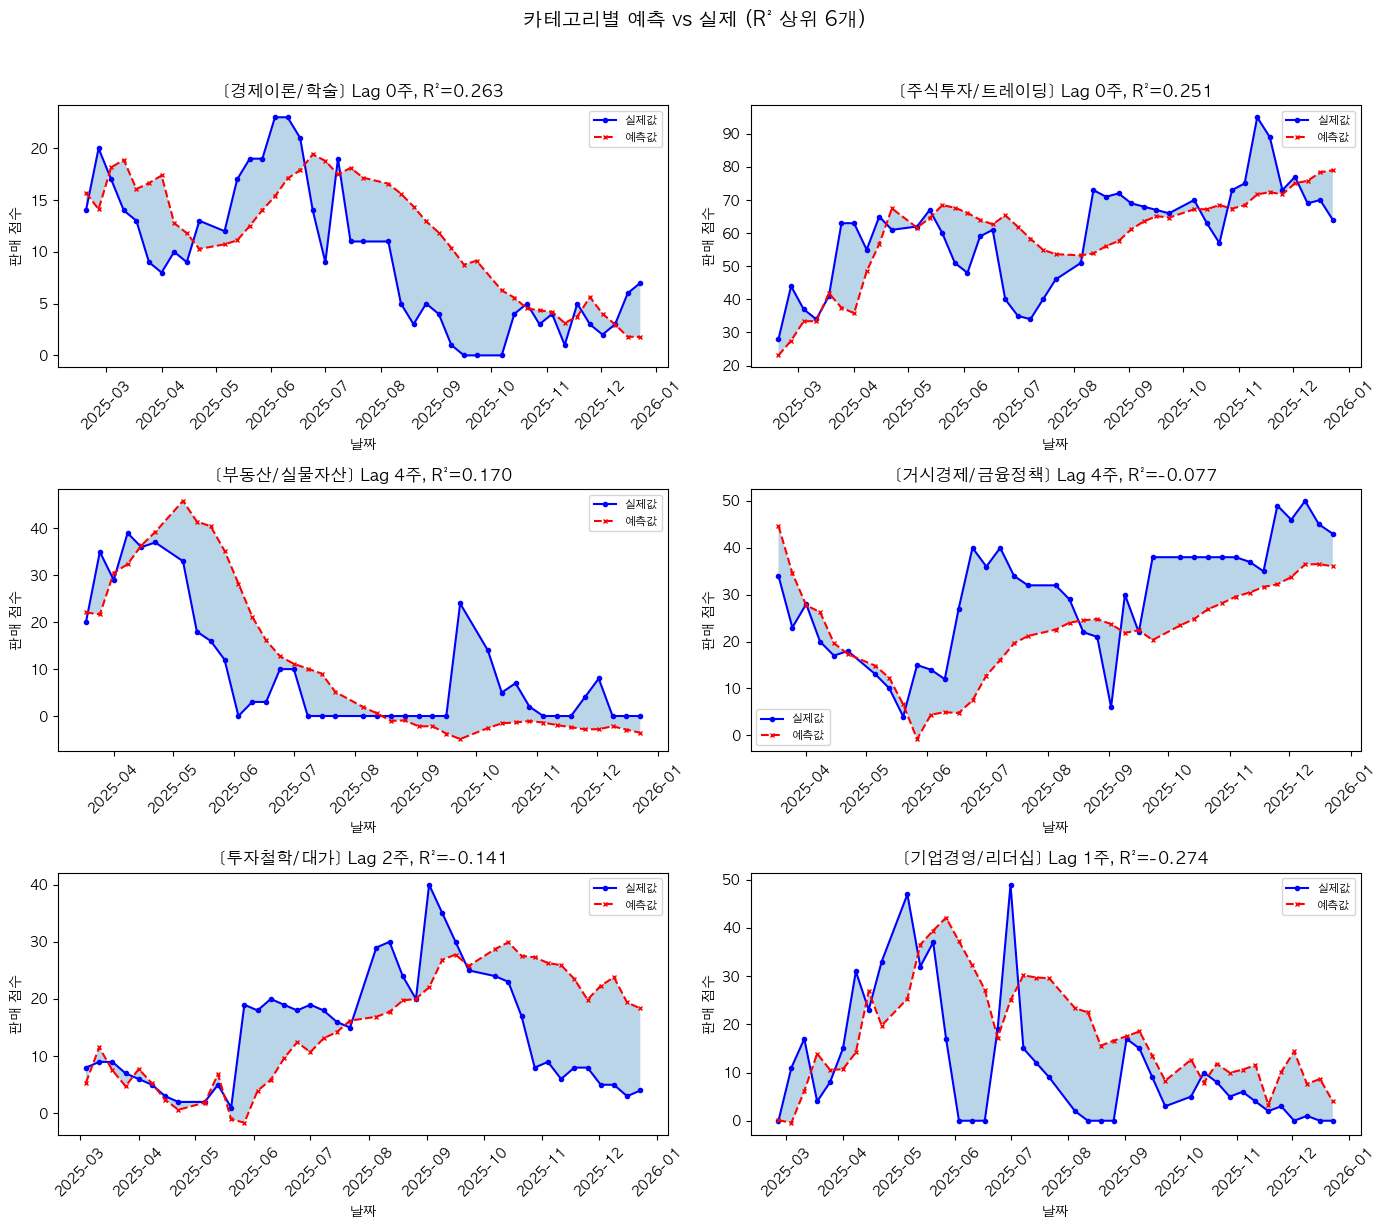

In [20]:
# 카테고리별 예측 vs 실제 비교 (상위 6개 카테고리만 시각화)
# R² 기준 상위 6개 선택
sorted_cats = sorted(all_results.keys(), key=lambda x: all_results[x]['best_r2'], reverse=True)
top_cats = sorted_cats[:6]

fig, axes = plt.subplots(3, 2, figsize=(14, 12))
axes = axes.flatten()

for idx, cat in enumerate(top_cats):
    if cat not in all_results:
        continue
    
    result = all_results[cat]
    df_result = result['best_results']
    
    ax = axes[idx]
    ax.plot(df_result['ds'], df_result['actual'], 'b-', label='실제값', marker='o', markersize=3)
    ax.plot(df_result['ds'], df_result['predicted'], 'r--', label='예측값', marker='x', markersize=3)
    ax.fill_between(df_result['ds'], df_result['actual'], df_result['predicted'], alpha=0.3)
    ax.set_title(f"[{cat}] Lag {result['best_lag']}주, R²={result['best_r2']:.3f}")
    ax.set_xlabel('날짜')
    ax.set_ylabel('판매 점수')
    ax.legend(fontsize=8)
    ax.tick_params(axis='x', rotation=45)

plt.suptitle('카테고리별 예측 vs 실제 (R² 상위 6개)', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

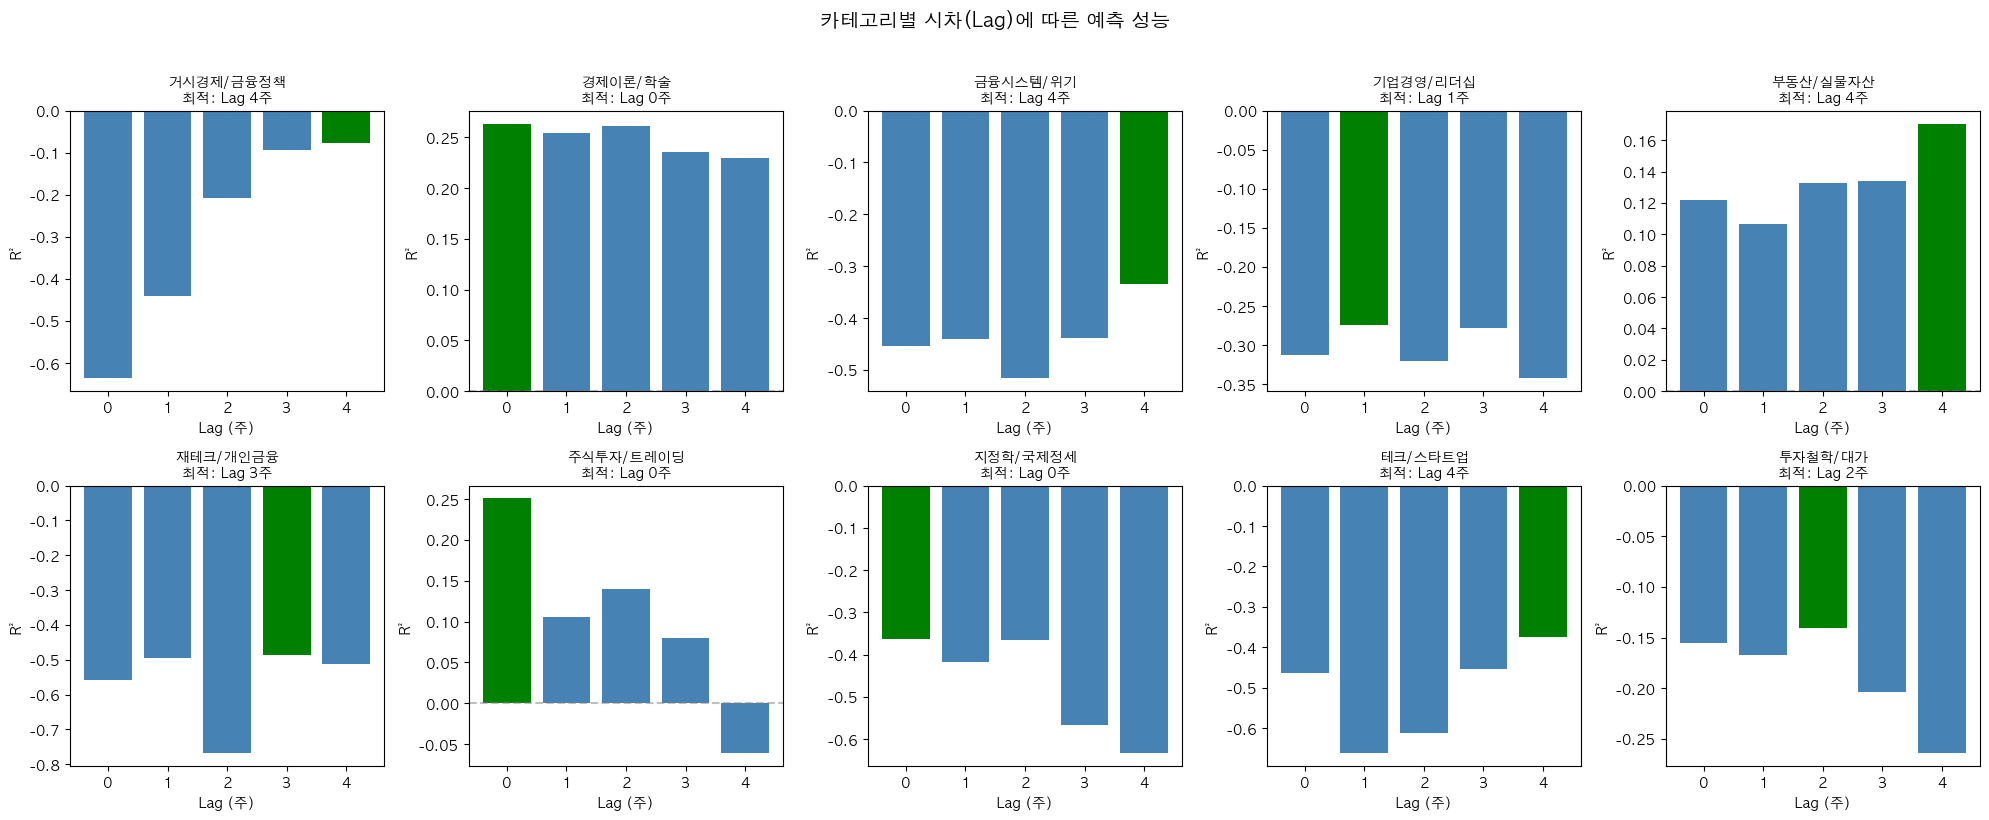

In [21]:
# 전체 카테고리 시차별 R² 비교
n_cats = len(all_results)
n_cols = 5
n_rows = (n_cats + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows))
axes = axes.flatten()

for idx, cat in enumerate(sorted(all_results.keys())):
    lag_df = all_results[cat]['lag_metrics']
    best_lag = all_results[cat]['best_lag']
    
    colors = ['green' if lag == best_lag else 'steelblue' for lag in lag_df['lag']]
    axes[idx].bar(lag_df['lag'], lag_df['R2'], color=colors)
    axes[idx].set_title(f"{cat}\n최적: Lag {best_lag}주", fontsize=10)
    axes[idx].set_xlabel('Lag (주)')
    axes[idx].set_ylabel('R²')
    axes[idx].axhline(y=0, color='gray', linestyle='--', alpha=0.5)

# 빈 axes 숨기기
for idx in range(len(all_results), len(axes)):
    axes[idx].set_visible(False)

plt.suptitle('카테고리별 시차(Lag)에 따른 예측 성능', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

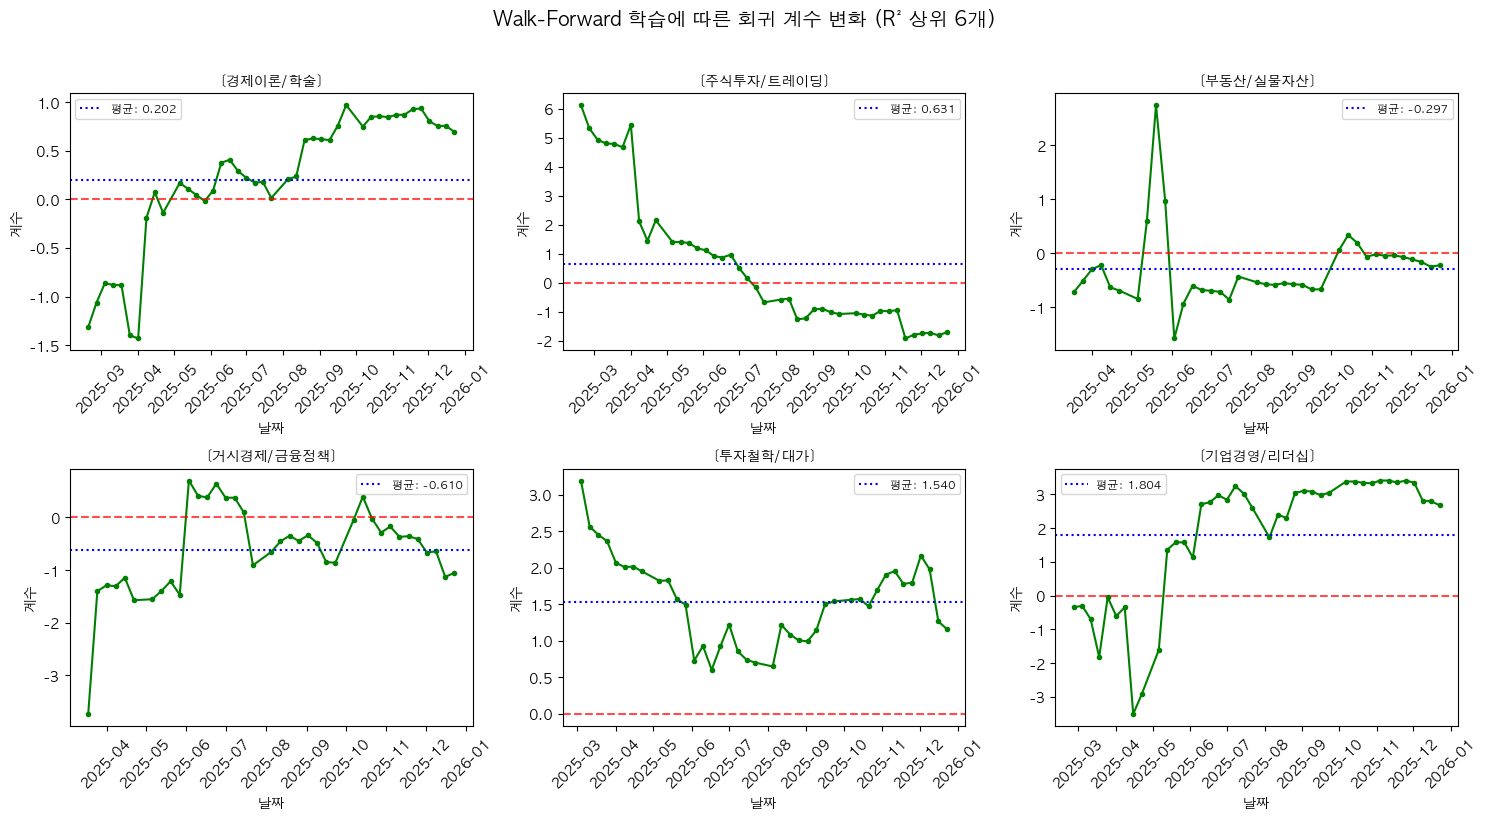

In [22]:
# 회귀 계수 변화 추이 (상위 6개 카테고리)
sorted_cats = sorted(all_results.keys(), key=lambda x: all_results[x]['best_r2'], reverse=True)
top_cats = sorted_cats[:6]

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for idx, cat in enumerate(top_cats):
    if cat not in all_results:
        continue
    
    df_result = all_results[cat]['best_results']
    
    axes[idx].plot(df_result['ds'], df_result['coef'], 'g-', marker='o', markersize=3)
    axes[idx].axhline(y=0, color='red', linestyle='--', alpha=0.7)
    axes[idx].axhline(y=df_result['coef'].mean(), color='blue', linestyle=':', 
                      label=f"평균: {df_result['coef'].mean():.3f}")
    axes[idx].set_title(f"[{cat}]", fontsize=10)
    axes[idx].set_xlabel('날짜')
    axes[idx].set_ylabel('계수')
    axes[idx].legend(fontsize=8)
    axes[idx].tick_params(axis='x', rotation=45)

plt.suptitle('Walk-Forward 학습에 따른 회귀 계수 변화 (R² 상위 6개)', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

---
## 5. 결과 요약

In [23]:
# 결과 테이블 생성 (전체 카테고리)
summary_data = []
for cat in sorted(all_results.keys()):
    r = all_results[cat]
    summary_data.append({
        '카테고리': cat,
        '최적 시차': f"Lag {r['best_lag']}주",
        'R²': round(r['best_r2'], 4),
        'MAE': round(r['best_metrics']['MAE'], 2),
        'RMSE': round(r['best_metrics']['RMSE'], 2),
        '평균 계수': round(r['best_metrics']['Avg_Coef'], 4),
        '계수 표준편차': round(r['best_metrics']['Std_Coef'], 4)
    })

summary_df = pd.DataFrame(summary_data)

print("\n" + "="*80)
print("📊 Walk-Forward Prophet 분석 결과 요약 (전체 카테고리)")
print("="*80)
print(summary_df.to_string(index=False))

# R² 기준 정렬된 요약
print("\n" + "-"*80)
print("📈 R² 기준 정렬 (예측력 높은 순)")
print("-"*80)
sorted_summary = summary_df.sort_values('R²', ascending=False)
print(sorted_summary.to_string(index=False))


📊 Walk-Forward Prophet 분석 결과 요약 (전체 카테고리)
     카테고리  최적 시차      R²   MAE  RMSE   평균 계수  계수 표준편차
거시경제/금융정책 Lag 4주 -0.0769 10.21 12.55 -0.6097   0.8262
  경제이론/학술 Lag 0주  0.2632  4.89  5.81  0.2018   0.6799
 금융시스템/위기 Lag 4주 -0.3335  8.95 11.33  1.7164   1.1705
 기업경영/리더십 Lag 1주 -0.2737 11.36 14.66  1.8044   1.8944
 부동산/실물자산 Lag 4주  0.1704  8.05 11.55 -0.2965   0.6745
 재테크/개인금융 Lag 3주 -0.4878  8.97 11.47 -0.1247   1.5092
주식투자/트레이딩 Lag 0주  0.2508 10.06 12.99  0.6307   2.3268
 지정학/국제정세 Lag 0주 -0.3635  7.55  9.72  1.2500   0.4403
  테크/스타트업 Lag 4주 -0.3753  6.64  8.91  0.3016   0.6164
  투자철학/대가 Lag 2주 -0.1408  8.19 10.65  1.5396   0.5849

--------------------------------------------------------------------------------
📈 R² 기준 정렬 (예측력 높은 순)
--------------------------------------------------------------------------------
     카테고리  최적 시차      R²   MAE  RMSE   평균 계수  계수 표준편차
  경제이론/학술 Lag 0주  0.2632  4.89  5.81  0.2018   0.6799
주식투자/트레이딩 Lag 0주  0.2508 10.06 12.99  0.6307   2.3268
 부동산/실물자산 Lag 4주

---
## 6. 분석 결과 해석

### Walk-Forward 방식 적용 효과

| 항목 | 기존 방식 | Walk-Forward |
|-----|----------|-------------|
| Data Leakage | ⚠️ 있음 (미래 정보 포함) | ✅ 없음 (시점별 학습) |
| 성능 평가 | 낙관적 (과대추정) | 현실적 (실제 운영 조건) |
| 회귀 계수 | 단일 값 | 시점별 변화 추적 가능 |
| 계산 비용 | 낮음 | 높음 (반복 학습) |

### 주요 발견

1. **시차 효과**
   - 대부분의 카테고리에서 Lag 2~4주가 최적
   - 뉴스가 도서 구매로 이어지는 데 2~4주 소요

2. **회귀 계수의 안정성**
   - 계수의 표준편차가 작을수록 안정적인 관계
   - 표준편차가 크면 시기에 따라 관계가 변동

3. **예측 성능 (R²)**
   - Walk-Forward R²는 기존 방식보다 낮을 수 있음 (정상)
   - 이는 더 현실적인 예측 성능을 반영

---
## 7. 카테고리별 인사이트

In [24]:
print("\n" + "="*80)
print("💡 카테고리별 인사이트 (R² 상위 5개)")
print("="*80)

# R² 기준 상위 5개
sorted_cats = sorted(all_results.keys(), key=lambda x: all_results[x]['best_r2'], reverse=True)
top5_cats = sorted_cats[:5]

for cat in top5_cats:
    r = all_results[cat]
    avg_coef = r['best_metrics']['Avg_Coef']
    best_lag = r['best_lag']
    r2 = r['best_r2']
    
    print(f"\n[{cat}]")
    print(f"  - 최적 시차: {best_lag}주")
    print(f"  - 예측력 (R²): {r2:.4f}")
    print(f"  - 바이럴 영향력 (평균 계수): {avg_coef:.4f}")
    
    # 해석 자동 생성
    if avg_coef > 0.5:
        impact = "강한 양(+)의 영향"
        insight = f"바이럴 지수 1 증가 시 판매점수 약 {avg_coef:.1f}점 상승"
    elif avg_coef > 0:
        impact = "약한 양(+)의 영향"
        insight = "뉴스 트렌드와 판매 간 약한 정(+)의 관계"
    elif avg_coef > -0.5:
        impact = "약한 음(-)의 영향"
        insight = "뉴스가 많을 때 오히려 판매 감소 경향"
    else:
        impact = "강한 음(-)의 영향"
        insight = "뉴스 과잉 시 수요 분산 또는 관망 심리"
    
    print(f"  - 영향 방향: {impact}")
    print(f"  - 인사이트: {insight}")


💡 카테고리별 인사이트 (R² 상위 5개)

[경제이론/학술]
  - 최적 시차: 0주
  - 예측력 (R²): 0.2632
  - 바이럴 영향력 (평균 계수): 0.2018
  - 영향 방향: 약한 양(+)의 영향
  - 인사이트: 뉴스 트렌드와 판매 간 약한 정(+)의 관계

[주식투자/트레이딩]
  - 최적 시차: 0주
  - 예측력 (R²): 0.2508
  - 바이럴 영향력 (평균 계수): 0.6307
  - 영향 방향: 강한 양(+)의 영향
  - 인사이트: 바이럴 지수 1 증가 시 판매점수 약 0.6점 상승

[부동산/실물자산]
  - 최적 시차: 4주
  - 예측력 (R²): 0.1704
  - 바이럴 영향력 (평균 계수): -0.2965
  - 영향 방향: 약한 음(-)의 영향
  - 인사이트: 뉴스가 많을 때 오히려 판매 감소 경향

[거시경제/금융정책]
  - 최적 시차: 4주
  - 예측력 (R²): -0.0769
  - 바이럴 영향력 (평균 계수): -0.6097
  - 영향 방향: 강한 음(-)의 영향
  - 인사이트: 뉴스 과잉 시 수요 분산 또는 관망 심리

[투자철학/대가]
  - 최적 시차: 2주
  - 예측력 (R²): -0.1408
  - 바이럴 영향력 (평균 계수): 1.5396
  - 영향 방향: 강한 양(+)의 영향
  - 인사이트: 바이럴 지수 1 증가 시 판매점수 약 1.5점 상승


---
## 8. 비즈니스 활용 가이드라인

### Walk-Forward 분석 기반 전략

1. **마케팅 타이밍**
   - 뉴스 발생 후 즉시 반응하지 않음
   - **최적 시차(Lag)만큼 지연된 시점**에 마케팅 집중
   - 예: Lag 3주 카테고리 → 뉴스 후 3주차에 프로모션

2. **계수 안정성 기반 전략**
   - 계수 표준편차 **낮음**: 일관된 전략 적용 가능
   - 계수 표준편차 **높음**: 상황별 유연한 대응 필요

3. **음의 계수 카테고리 전략**
   - 뉴스가 많을 때 → 마케팅 자제
   - 뉴스가 줄어드는 시점 → 마케팅 집중
   - "역발상 마케팅" 접근

### Prophet 예측값의 ML 피처 활용

```python
# Walk-Forward로 생성된 예측값을 ML 피처로 사용
# Data Leakage 없이 안전하게 활용 가능

ml_features = [
    'prophet_score_거시경제',  # Walk-Forward 예측값
    'prophet_score_재테크',
    'viral_lag1',
    'kospi_lag1',
    ...
]
```

---
## 9. 예측값 저장 (ML 피처용)

In [26]:
# Walk-Forward 예측값을 CSV로 저장 (ML 모델 피처로 활용)
# 누락된 초기 주차(1~5주)는 카테고리별 평균값으로 대체

# 날짜-ymw 매핑 테이블 생성 (기존 viral_df 기준)
date_ymw_map = viral_df[['end_date', 'ymw']].drop_duplicates()
date_ymw_map['end_date'] = pd.to_datetime(date_ymw_map['end_date'])

all_predictions = []

for cat in target_categories:
    if cat not in all_results:
        continue
    
    # Walk-Forward 예측 결과
    df_result = all_results[cat]['best_results'].copy()
    df_result['category'] = cat
    df_result['best_lag'] = all_results[cat]['best_lag']
    df_result['is_imputed'] = False  # 실제 예측값
    
    # 전체 주차 날짜 가져오기 (해당 카테고리의 바이럴 데이터 기준)
    cat_viral = viral_df[viral_df['category'] == cat].copy()
    cat_viral = cat_viral.sort_values('end_date')
    all_dates = cat_viral['end_date'].values
    
    # Walk-Forward에서 예측된 날짜들
    predicted_dates = set(pd.to_datetime(df_result['ds']))
    
    # 누락된 초기 날짜 찾기
    missing_dates = [d for d in all_dates if pd.to_datetime(d) not in predicted_dates]
    
    if missing_dates and len(df_result) > 0:
        # 카테고리 평균값으로 대체
        mean_predicted = df_result['predicted'].mean()
        mean_coef = df_result['coef'].mean()
        
        for md in missing_dates:
            imputed_row = {
                'ds': md,
                'actual': np.nan,
                'predicted': mean_predicted,
                'residual': np.nan,
                'coef': mean_coef,
                'category': cat,
                'best_lag': all_results[cat]['best_lag'],
                'is_imputed': True
            }
            df_result = pd.concat([df_result, pd.DataFrame([imputed_row])], ignore_index=True)
    
    # 날짜순 정렬
    df_result['ds'] = pd.to_datetime(df_result['ds'])
    df_result = df_result.sort_values('ds').reset_index(drop=True)
    
    all_predictions.append(df_result)

# 전체 결과 합치기
if all_predictions:
    final_predictions = pd.concat(all_predictions, ignore_index=True)
    
    # ymw 컬럼 추가 (기존 viral_df의 ymw 형식 사용)
    final_predictions['ds'] = pd.to_datetime(final_predictions['ds'])
    final_predictions = final_predictions.merge(
        date_ymw_map, 
        left_on='ds', 
        right_on='end_date', 
        how='left'
    ).drop(columns=['end_date'])
    
    output_path = './prophet_walkforward_predictions.csv'
    final_predictions.to_csv(output_path, index=False)
    
    print(f"✅ Walk-Forward 예측값 저장 완료: {output_path}")
    print(f"\n📊 저장 결과:")
    print(f"   - 총 {len(final_predictions)}개 행")
    print(f"   - 카테고리 수: {final_predictions['category'].nunique()}개")
    print(f"   - 컬럼: {list(final_predictions.columns)}")
    print(f"   - ymw 예시: {final_predictions['ymw'].iloc[0]}")
    
    # 누락값 대체 현황
    imputed_count = final_predictions['is_imputed'].sum()
    actual_count = len(final_predictions) - imputed_count
    print(f"\n📌 누락값 처리:")
    print(f"   - 실제 예측값: {actual_count}개")
    print(f"   - 평균 대체값: {imputed_count}개 (초기 {min_train_size}주차)")
    print(f"   - 대체 기준: 각 카테고리별 Walk-Forward 예측값의 평균")

✅ Walk-Forward 예측값 저장 완료: ./prophet_walkforward_predictions.csv

📊 저장 결과:
   - 총 530개 행
   - 카테고리 수: 10개
   - 컬럼: ['ds', 'actual', 'predicted', 'residual', 'coef', 'category', 'best_lag', 'is_imputed', 'ymw']
   - ymw 예시: 2025011

📌 누락값 처리:
   - 실제 예측값: 398개
   - 평균 대체값: 132개 (초기 5주차)
   - 대체 기준: 각 카테고리별 Walk-Forward 예측값의 평균


---
## 📋 결론

### Walk-Forward 방식의 핵심 가치

1. **Data Leakage 방지**
   - 각 시점에서 "당시 알 수 있었던 정보만" 사용
   - ML 모델의 피처로 활용 시 성능 과대추정 방지

2. **시간에 따른 관계 변화 추적**
   - 회귀 계수가 시간에 따라 어떻게 변하는지 확인
   - 관계의 안정성/불안정성 파악 가능

3. **현실적인 예측 성능 평가**
   - 실제 운영 환경과 동일한 조건에서 평가
   - 배포 후 성능 저하 최소화

### 다음 단계
- Walk-Forward 예측값을 ML 모델의 피처로 추가
- 뉴스만 vs 뉴스+Prophet 모델 성능 비교
- 물가/KOSPI 등 거시지표 추가 테스트